<a href="https://colab.research.google.com/github/simoneseverini/automated-discovery-site/blob/main/ABM_v2_Intelligence_Phase_Space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intelligence Crisis vs. Boom: Phase Space Model (v2)

**v2 fixes over v1:**
1. **Financial sector now bites.** Bank starts at 6% capital ratio (fragile, realistic for shadow banking), PE losses are scaled to actually impair the balance sheet, and credit tightening feeds back into accelerated automation and reduced reemployment.
2. **New-firm employment feedback.** Entrepreneurs hire from the unemployed pool directly, creating a genuine absorption mechanism. Boom scenario can actually reduce unemployment.
3. **Consumption rebalancing.** Deflation savings on existing goods create demand for new-sector goods, which generates revenue → employment → income → spending. The circular flow works both ways now.

These changes mean the model can produce genuine prosperity (Bloch) AND genuine crisis (Citrini), not two flavors of disruption.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
from dataclasses import dataclass
from typing import Dict
from copy import deepcopy
import warnings, time
warnings.filterwarnings('ignore')

plt.rcParams.update({
    'figure.facecolor': '#0d1117', 'axes.facecolor': '#0d1117',
    'axes.edgecolor': '#30363d', 'axes.labelcolor': '#c9d1d9',
    'text.color': '#c9d1d9', 'xtick.color': '#8b949e',
    'ytick.color': '#8b949e', 'grid.color': '#21262d',
    'figure.dpi': 110, 'font.size': 11,
})
CR='#f85149'; BM='#3fb950'; NT='#58a6ff'; WR='#d29922'
print("Environment ready")


Environment ready


## Parameters (v2)

In [2]:
@dataclass
class Params:
    n_households: int = 2000
    T: int = 120
    seed: int = 42

    # AI
    ai_growth_rate: float = 0.03
    base_ai_cost: float = 120.0
    automation_lag: float = 3.0

    # Labor
    wc_frac: float = 0.50
    wc_wage: float = 150.0
    bc_wage: float = 75.0
    wage_cv: float = 0.25
    downshift_penalty: float = 0.45

    # ━━━ PHASE-CRITICAL 1 ━━━
    entrepreneurship_rate: float = 0.08
    new_firm_cost: float = 80.0
    new_firm_survival: float = 0.97
    new_firm_emp: float = 3.0
    new_firm_rev_per_emp: float = 10.0
    # v2: new firms hire from unemployed pool
    new_firm_hiring_rate: float = 0.06  # monthly prob an unemployed person gets hired by new firm

    # ━━━ PHASE-CRITICAL 2 ━━━
    deflation_spending_rate: float = 0.50

    # Consumption
    mpc_income: float = 0.75
    mpc_savings: float = 0.02
    subsistence: float = 30.0

    # Pricing
    digital_frac: float = 0.40
    physical_floor: float = 55.0
    digital_floor: float = 1.0
    init_price: float = 100.0
    digital_defl_speed: float = 0.04
    physical_defl_speed: float = 0.005
    saas_erosion_start: float = 4.0
    saas_erosion_rate: float = 0.015

    # Housing
    home_income_mult: float = 5.0
    init_ltv: float = 0.78
    mortgage_rate: float = 0.065
    mortgage_term: int = 360
    default_income_ratio: float = 0.30   # v2: tighter — default if income < 30% of pmt
    default_savings_buffer: int = 3      # v2: shorter buffer
    home_price_speed: float = 0.03       # v2: faster adjustment
    foreclosure_discount: float = 0.25   # v2: deeper foreclosure haircut
    foreclosure_contagion: float = 0.003 # v2: each foreclosure depresses neighborhood

    # Finance — v2: FRAGILE by design
    pe_frac: float = 0.35               # v2: more PE-backed firms
    pe_leverage: float = 4.0            # v2: higher leverage
    bank_init_cap: float = 0.06         # v2: 6% — shadow banking level, not regulated bank
    # ━━━ PHASE-CRITICAL 3 ━━━
    financial_contagion: float = 0.50
    bank_cap_floor: float = 0.03
    corp_recovery: float = 0.35         # v2: lower recovery
    mort_recovery: float = 0.50         # v2: lower recovery
    # v2: credit tightening feedback loops
    credit_automation_boost: float = 0.02  # tighter credit → faster automation
    credit_reemploy_penalty: float = 0.5   # tighter credit → harder to find jobs
    credit_startup_penalty: float = 0.4    # tighter credit → harder to start firms

    # Equity
    div_payout: float = 0.25
    equity_pareto: float = 1.8
    # v2: wealth effect
    wealth_effect_mpc: float = 0.01  # MPC out of equity wealth changes

    # Government
    income_tax: float = 0.22
    corp_tax: float = 0.21
    ubi_trigger: float = 0.08
    ubi_amount: float = 55.0
    fiscal_lag: int = 6


def citrini_params():
    return Params(
        entrepreneurship_rate=0.03, deflation_spending_rate=0.15,
        financial_contagion=0.85, new_firm_survival=0.93,
        pe_leverage=5.0, bank_init_cap=0.05, fiscal_lag=9,
        new_firm_hiring_rate=0.02, corp_recovery=0.25,
        credit_automation_boost=0.03, credit_reemploy_penalty=0.7,
        credit_startup_penalty=0.6, foreclosure_contagion=0.005)

def bloch_params():
    return Params(
        entrepreneurship_rate=0.18, deflation_spending_rate=0.80,
        financial_contagion=0.15, new_firm_survival=0.98,
        pe_leverage=2.5, bank_init_cap=0.08, fiscal_lag=3,
        new_firm_hiring_rate=0.12, corp_recovery=0.45,
        credit_automation_boost=0.01, credit_reemploy_penalty=0.2,
        credit_startup_penalty=0.15, foreclosure_contagion=0.001)

print("Parameters defined (v2)")


Parameters defined (v2)


## Simulation Engine (v2)

In [3]:
def run_simulation(params):
    p = params
    rng = np.random.default_rng(p.seed)
    T, n_h = p.T, p.n_households

    # ── HOUSEHOLDS ──
    is_wc = np.zeros(n_h, dtype=bool)
    is_wc[:int(n_h * p.wc_frac)] = True
    rng.shuffle(is_wc)

    h_base = np.where(is_wc,
        p.wc_wage * (1 + p.wage_cv * rng.standard_normal(n_h)),
        p.bc_wage * (1 + p.wage_cv * rng.standard_normal(n_h))).clip(20)
    h_inc = h_base.copy()
    h_sav = h_inc * rng.uniform(3, 12, n_h)
    h_emp = np.ones(n_h, dtype=bool)
    h_ent = np.zeros(n_h, dtype=bool)
    h_umo = np.zeros(n_h, dtype=int)
    # v2: track which sector employs each household
    # 0=legacy, 1=new sector
    h_sector = np.zeros(n_h, dtype=int)

    # Housing
    h_hval = h_base * p.home_income_mult * rng.uniform(0.8, 1.2, n_h)
    h_mbal = h_hval * p.init_ltv
    mr = p.mortgage_rate / 12
    h_mpmt = h_mbal * mr / (1 - (1+mr)**(-p.mortgage_term))
    h_def = np.zeros(n_h, dtype=bool)

    # Equity (Pareto, correlated with income)
    raw_eq = rng.pareto(p.equity_pareto, n_h)
    h_eqsh = np.zeros(n_h)
    h_eqsh[np.argsort(np.argsort(h_base))] = np.sort(raw_eq)
    h_eqsh /= h_eqsh.sum()

    # ── FIRMS ──
    n_dig = int(100 * p.digital_frac)
    n_phy = 100 - n_dig
    n_new = 0
    dig_emp = float(n_dig * 15)
    phy_emp = float(n_phy * 20)
    new_emp = 0.0
    dig_rev = dig_emp * 12.0
    phy_rev = phy_emp * 8.0
    new_rev = 0.0
    dig_price, phy_price, new_price = p.init_price, p.init_price, p.init_price * 0.7
    dig_auto, phy_auto = 0.0, 0.0

    # v2: PE debt is large relative to bank capital
    n_pe = int(n_dig * p.pe_frac)
    pe_debt_initial = n_pe * 15 * 12 * p.pe_leverage
    pe_debt_remaining = pe_debt_initial
    pe_firms_alive = n_pe

    # ── BANK ──
    tot_mort = h_mbal.sum()
    bank_assets = tot_mort + pe_debt_initial
    bank_cap = bank_assets * p.bank_init_cap
    credit_tight = 0.0

    # ── GOVERNMENT ──
    ubi_on = False; ubi_wait = 0; cum_deficit = 0.0

    # ── EQUITY MARKET ──
    prev_sp = 1.0  # for wealth effect

    # ── STORAGE ──
    keys = ['unemp','wc_unemp','gdp_idx','med_inc','purch_pwr','consumption',
            'hpi','mort_def','sp500','gini','n_firms','n_new','new_mo',
            'ai_cap','dig_px','phy_px','bank_cap_r','credit_tight','deficit_flow',
            'cum_deficit','velocity','labor_share','ubi_on','wc_med_inc',
            'dig_emp','phy_emp','new_emp_ts','avg_sav','ent_flow',
            'pe_default_rate','new_sector_emp_share','reemploy_mo',
            'mort_def_flow','wealth_effect']
    ts = {k: np.zeros(T) for k in keys}

    init_gdp = h_inc.sum()
    init_med = np.median(h_inc)
    init_sp_val = dig_rev * 8 + phy_rev * 5
    init_wc_med = np.median(h_inc[is_wc])
    hpm = 1.0

    for t in range(T):
        # 1. AI
        ai = (1 + p.ai_growth_rate) ** t
        ai_cost = p.base_ai_cost / ai

        # 2. Automation — v2: credit stress accelerates automation
        wc_w = h_inc[is_wc & h_emp].mean() if (is_wc & h_emp).any() else p.wc_wage
        bc_w = h_inc[~is_wc & h_emp].mean() if (~is_wc & h_emp).any() else p.bc_wage

        auto_boost = 1 + credit_tight * p.credit_automation_boost
        if ai_cost < wc_w / p.automation_lag:
            dig_auto = min(0.95, dig_auto + 0.04 * auto_boost)
        if ai_cost < bc_w / p.automation_lag:
            phy_auto = min(0.70, phy_auto + 0.01 * auto_boost)

        dig_tgt = n_dig * 15.0 * (1 - dig_auto)
        phy_tgt = n_phy * 20.0 * (1 - phy_auto)
        layoffs = max(0, dig_emp - dig_tgt) + max(0, phy_emp - phy_tgt)
        dig_emp = max(dig_tgt, n_dig * 0.5)
        phy_emp = max(phy_tgt, n_phy * 2.0)

        # 3. Displacement
        n_disp = min(int(layoffs * n_h / max(1, n_dig*15 + n_phy*20)),
                     int(h_emp.sum() * 0.04))
        if n_disp > 0:
            wc_pool = np.where(is_wc & h_emp & ~h_ent & (h_sector==0))[0]
            bc_pool = np.where(~is_wc & h_emp & ~h_ent & (h_sector==0))[0]
            n_wc = min(int(n_disp * 0.7), len(wc_pool))
            n_bc = min(n_disp - n_wc, len(bc_pool))
            if n_wc > 0:
                idx = rng.choice(wc_pool, n_wc, replace=False)
                h_emp[idx] = False; h_umo[idx] = 0
            if n_bc > 0:
                idx = rng.choice(bc_pool, n_bc, replace=False)
                h_emp[idx] = False; h_umo[idx] = 0

        h_umo[~h_emp & ~h_ent] += 1

        # 4. Entrepreneurship, new-firm hiring, reemployment
        unemp_mask = ~h_emp & ~h_ent & ~h_def
        n_unemp = unemp_mask.sum()
        new_ent_ct = 0
        reemploy_ct = 0
        new_hire_ct = 0

        if n_unemp > 0:
            ui = np.where(unemp_mask)[0]
            scost = p.new_firm_cost / (1 + 0.5 * np.log1p(ai))

            # v2: credit tightening penalizes startups
            eff_ent = min(0.30, p.entrepreneurship_rate * (1 + 0.3*np.log1p(ai)))
            eff_ent *= (1 - credit_tight * p.credit_startup_penalty)
            eff_ent = max(0, eff_ent)

            can_aff = h_sav[ui] > scost
            becomes = (rng.random(n_unemp) < eff_ent) & can_aff
            ei = ui[becomes]
            if len(ei) > 0:
                h_ent[ei] = True; h_emp[ei] = True; h_sector[ei] = 1
                h_sav[ei] -= scost
                h_inc[ei] = p.new_firm_rev_per_emp * p.new_firm_emp * 0.3
                new_ent_ct = len(ei)
                n_new += new_ent_ct
                new_emp += new_ent_ct * p.new_firm_emp
                new_rev += new_ent_ct * p.new_firm_emp * p.new_firm_rev_per_emp

            # v2: NEW FIRM HIRING — unemployed get absorbed by new-sector firms
            still_unemp = np.where(~h_emp & ~h_ent & ~h_def)[0]
            if len(still_unemp) > 0 and n_new > 0:
                hire_prob = p.new_firm_hiring_rate * (n_new / max(1, n_new + 50))
                hire_prob *= (1 - credit_tight * p.credit_reemploy_penalty * 0.5)
                hire_prob = max(0, min(0.20, hire_prob))
                hired = still_unemp[rng.random(len(still_unemp)) < hire_prob]
                if len(hired) > 0:
                    h_emp[hired] = True; h_sector[hired] = 1
                    h_inc[hired] = np.where(is_wc[hired],
                        p.bc_wage * 0.8 * rng.uniform(0.8,1.2,len(hired)),
                        p.bc_wage * 0.9 * rng.uniform(0.8,1.2,len(hired)))
                    h_umo[hired] = 0
                    new_hire_ct = len(hired)
                    new_emp += new_hire_ct

            # Legacy-sector reemployment — v2: penalized by credit tightening
            still_unemp2 = np.where(~h_emp & ~h_ent & ~h_def)[0]
            if len(still_unemp2) > 0:
                rp = 0.06 * np.exp(-0.1 * h_umo[still_unemp2])
                rp *= (1 - credit_tight * p.credit_reemploy_penalty)
                rp = np.clip(rp, 0, 1)
                rehire = still_unemp2[rng.random(len(still_unemp2)) < rp]
                if len(rehire) > 0:
                    h_emp[rehire] = True; h_sector[rehire] = 0
                    h_inc[rehire] = np.where(is_wc[rehire],
                        p.bc_wage * p.downshift_penalty * rng.uniform(0.8,1.2,len(rehire)),
                        h_base[rehire] * 0.85)
                    h_umo[rehire] = 0
                    reemploy_ct = len(rehire)

        # New firm attrition
        if n_new > 0:
            dying = rng.binomial(max(0,int(n_new)), float(np.clip(1-p.new_firm_survival,0,1)))
            if dying > 0:
                n_new = max(0, n_new - dying)
                lost = dying * p.new_firm_emp
                new_emp = max(0, new_emp - lost)
                new_rev = max(0, new_rev - lost * p.new_firm_rev_per_emp)
                eidx = np.where(h_ent)[0]
                if len(eidx) > 0:
                    nf = min(dying, len(eidx))
                    failed = rng.choice(eidx, nf, replace=False)
                    h_ent[failed] = False; h_emp[failed] = False
                    h_sector[failed] = 0; h_umo[failed] = 0

        # Entrepreneur income growth
        if h_ent.any():
            h_inc[h_ent] *= (1 + 0.03 * min(ai/5, 1.0))
            h_inc[h_ent] = h_inc[h_ent].clip(max=p.wc_wage * 3)

        h_inc[~h_emp] = 0

        # 5. Pricing
        if ai > 2.0:
            dig_price = max(p.digital_floor,
                           dig_price * (1 - p.digital_defl_speed * min(ai/10, 1.0)))
        phy_price = max(p.physical_floor, phy_price * (1 - p.physical_defl_speed))
        if n_new > 0:
            new_price = max(35.0, new_price * 0.997)

        tot_f = max(1, n_dig + n_phy + n_new)
        px_idx = (n_dig*dig_price + n_phy*phy_price + n_new*new_price) / (tot_f * p.init_price)

        if ai > p.saas_erosion_start:
            er = p.saas_erosion_rate * (ai - p.saas_erosion_start) / 10
            dig_rev *= (1 - min(er, 0.06))
            dig_rev = max(dig_rev, n_dig * 1.0)

        # 6. Consumption — v2: includes wealth effect
        urate = 1 - h_emp.sum() / n_h
        if urate > p.ubi_trigger and not ubi_on:
            ubi_wait += 1
            if ubi_wait >= p.fiscal_lag: ubi_on = True
        elif urate <= p.ubi_trigger * 0.6:
            ubi_on = False; ubi_wait = 0

        ubi_pmt = p.ubi_amount if ubi_on else 0.0
        profits = max(0, (dig_rev + phy_rev + new_rev) * 0.15)
        div_pool = profits * p.div_payout
        h_div = h_eqsh * div_pool
        h_gross = h_inc + ubi_pmt + h_div

        defl_sav = max(0, (1 - px_idx) * p.init_price * 0.5)

        # v2: wealth effect from equity changes
        sp_current = (dig_rev * max(2, 8*(1-dig_auto*0.3)) +
                     phy_rev * 5 +
                     new_rev * max(3, 12*(1-credit_tight))) * (1 - credit_tight*0.4)
        sp_norm = sp_current / max(1, init_sp_val)
        wealth_delta = (sp_norm - prev_sp) * init_sp_val
        wealth_effect = h_eqsh * wealth_delta * p.wealth_effect_mpc
        prev_sp = sp_norm

        h_cons = (h_gross * p.mpc_income +
                  h_sav.clip(0) * p.mpc_savings +
                  defl_sav * p.deflation_spending_rate +
                  wealth_effect.clip(min=-p.subsistence*0.5)).clip(min=p.subsistence)

        mort_mask = (h_mbal > 0) & ~h_def
        h_sav += h_gross - h_cons - h_mpmt * mort_mask
        h_sav = h_sav.clip(min=-h_hval * 0.1)
        tot_cons = h_cons.sum()

        # 7. Housing — v2: stronger contagion
        cur_agg_inc = h_inc[h_emp].sum()
        init_agg = h_base.sum()
        inc_ratio = cur_agg_inc / max(init_agg * 0.1, init_agg)
        hpm += (inc_ratio - hpm) * p.home_price_speed

        # v2: wealth effect on home prices too
        hpm *= (1 + (sp_norm - 1) * 0.002)
        hpm = max(0.3, hpm)

        h_hval_cur = h_hval * hpm

        at_risk = (mort_mask &
                   (h_gross < h_mpmt * p.default_income_ratio) &
                   (h_sav < h_mpmt * p.default_savings_buffer))
        new_def = at_risk & (rng.random(n_h) < 0.20)  # v2: higher default prob if distressed
        h_def |= new_def
        n_new_def = new_def.sum()

        if n_new_def > 0:
            floss = (h_mbal[new_def] - h_hval_cur[new_def]*(1-p.foreclosure_discount)).clip(0).sum()
            h_mbal[new_def] = 0; h_mpmt[new_def] = 0
            h_hval[new_def] *= (1 - p.foreclosure_discount)
            hpm *= (1 - p.foreclosure_contagion * n_new_def)
        else:
            floss = 0

        # 8. Financial contagion — v2: PE defaults are LARGE relative to bank capital
        pe_dp = 0.0
        pe_defaults_this = 0
        if ai > p.saas_erosion_start and pe_firms_alive > 0:
            rdecl = max(0, 1 - dig_rev / max(1, n_dig * 15 * 12))
            pe_dp = min(0.08, max(0, rdecl * 0.15 * (1 + credit_tight * 2)))
            pe_defaults_this = rng.binomial(max(0, pe_firms_alive),
                                           float(np.clip(pe_dp, 0, 1)))
            pe_firms_alive = max(0, pe_firms_alive - pe_defaults_this)

        # v2: each PE default destroys leveraged debt
        pe_loss_per_firm = 15 * 12 * p.pe_leverage  # revenue-based debt
        pe_loss = pe_defaults_this * pe_loss_per_firm * (1 - p.corp_recovery)
        mort_loss = floss * (1 - p.mort_recovery)

        total_loss = pe_loss + mort_loss
        bank_cap = max(0, bank_cap - total_loss)

        # v2: bank assets shrink with defaults
        bank_assets = h_mbal[~h_def].sum() + pe_firms_alive * pe_loss_per_firm / (1-p.corp_recovery)
        bank_assets = max(1, bank_assets)
        bcr = bank_cap / bank_assets

        # v2: contagion strength determines how aggressively stress transmits
        if bcr < p.bank_init_cap:
            stress = (p.bank_init_cap - bcr) / max(0.01, p.bank_init_cap)
            credit_tight = min(1.0, stress * p.financial_contagion * 2.5)
        else:
            credit_tight = max(0, credit_tight - 0.03)

        pe_debt_remaining = pe_firms_alive * pe_loss_per_firm / (1-p.corp_recovery)

        # 9. Revenue — v2: new sector revenue driven by consumption + hiring
        c_share_new = min(0.4, 0.05 + 0.35 * n_new / max(1, n_new + 80))
        c_share_dig = max(0.1, 0.35 * (1 - 0.5 * dig_auto) * (1 - c_share_new/0.5))
        c_share_phy = 1 - c_share_dig - c_share_new

        dig_rev = tot_cons * c_share_dig * (dig_price / p.init_price)
        phy_rev = tot_cons * c_share_phy * (phy_price / p.init_price)
        new_rev = (tot_cons * c_share_new +
                   n_new * p.new_firm_rev_per_emp * p.new_firm_emp * 0.5)

        # 10. Government
        tax_rev = h_inc[h_emp].sum() * p.income_tax + profits * p.corp_tax
        govt_out = ubi_pmt * n_h + n_h * 10
        dflow = govt_out - tax_rev
        cum_deficit += dflow

        # 11. Equity — v2: new sector gets growth multiple
        dm = max(2, 8 * (1 - dig_auto * 0.4))
        nm = max(4, 15 * (1 - credit_tight * 0.5))  # v2: higher multiple for growth
        sp = (dig_rev*dm + phy_rev*5 + new_rev*nm) * (1 - credit_tight * 0.4)

        # 12. Record
        ne = h_emp.sum()
        new_sector_ne = (h_sector == 1).sum()

        ts['unemp'][t] = 1 - ne/n_h
        ts['wc_unemp'][t] = 1 - (is_wc & h_emp).sum() / max(1, is_wc.sum())
        ts['gdp_idx'][t] = tot_cons / max(1, init_gdp) * 100
        ts['med_inc'][t] = np.median(h_gross) / max(1, init_med) * 100
        ts['purch_pwr'][t] = np.median(h_gross) / max(0.01, px_idx) / init_med * 100
        ts['consumption'][t] = tot_cons
        ts['hpi'][t] = hpm * 100
        ts['mort_def'][t] = h_def.sum() / n_h * 100
        ts['mort_def_flow'][t] = n_new_def
        ts['sp500'][t] = sp / max(1, init_sp_val) * 100
        ts['n_firms'][t] = n_dig + n_phy + n_new
        ts['n_new'][t] = n_new
        ts['new_mo'][t] = new_ent_ct
        ts['ai_cap'][t] = ai
        ts['dig_px'][t] = dig_price / p.init_price * 100
        ts['phy_px'][t] = phy_price / p.init_price * 100
        ts['bank_cap_r'][t] = bcr * 100
        ts['credit_tight'][t] = credit_tight * 100
        ts['deficit_flow'][t] = dflow
        ts['cum_deficit'][t] = cum_deficit
        ts['velocity'][t] = tot_cons / max(1, h_sav.clip(0).sum()) * 12
        ts['labor_share'][t] = h_inc[h_emp].sum() / max(1, tot_cons + profits) * 100
        ts['ubi_on'][t] = float(ubi_on)
        ts['wc_med_inc'][t] = np.median(h_gross[is_wc])/max(1,init_wc_med)*100 if is_wc.any() else 0
        ts['dig_emp'][t] = dig_emp; ts['phy_emp'][t] = phy_emp
        ts['new_emp_ts'][t] = new_emp
        ts['avg_sav'][t] = h_sav.mean()
        ts['ent_flow'][t] = new_ent_ct
        ts['pe_default_rate'][t] = pe_defaults_this / max(1, pe_firms_alive + pe_defaults_this) * 100
        ts['new_sector_emp_share'][t] = new_sector_ne / max(1, ne) * 100
        ts['reemploy_mo'][t] = reemploy_ct + new_hire_ct
        ts['wealth_effect'][t] = wealth_delta

        sg = np.sort(h_gross); n=len(sg); ix=np.arange(1,n+1)
        ts['gini'][t] = (2*np.sum(ix*sg)/(n*np.sum(sg))-(n+1)/n) if sg.sum()>0 else 0

    return ts

print("Simulation engine v2 defined")


Simulation engine v2 defined


## Visualization

In [4]:
def plot_scenario(ts, title, params):
    mo = np.arange(params.T); yr = 2026 + mo/12
    fig = plt.figure(figsize=(22, 28))
    gs = gridspec.GridSpec(6, 3, hspace=0.35, wspace=0.3,
                          left=0.06, right=0.97, top=0.96, bottom=0.03)
    def ax(r,c,t):
        a=fig.add_subplot(gs[r,c]); a.set_title(t,fontsize=11,fontweight='bold',pad=8)
        a.grid(True,alpha=0.15); return a

    # Row 0: Macro
    a=ax(0,0,'Unemployment Rate')
    a.plot(yr,ts['unemp']*100,color=CR,lw=2,label='Total')
    a.plot(yr,ts['wc_unemp']*100,color=WR,lw=1.5,ls='--',label='White-collar')
    a.axhline(8,color='#8b949e',ls=':',alpha=0.5); a.set_ylabel('%'); a.legend(fontsize=8)

    a=ax(0,1,'GDP Index'); a.plot(yr,ts['gdp_idx'],color=NT,lw=2)
    a.axhline(100,color='#8b949e',ls=':',alpha=0.5); a.set_ylabel('Index')

    a=ax(0,2,'S&P 500 Proxy')
    c=BM if ts['sp500'][-1]>100 else CR
    a.plot(yr,ts['sp500'],color=c,lw=2); a.axhline(100,color='#8b949e',ls=':',alpha=0.5)

    # Row 1: Income
    a=ax(1,0,'Real Purchasing Power')
    c=BM if ts['purch_pwr'][-1]>100 else CR
    a.plot(yr,ts['purch_pwr'],color=c,lw=2); a.axhline(100,color='#8b949e',ls=':',alpha=0.5)

    a=ax(1,1,'Gini Coefficient'); a.plot(yr,ts['gini'],color=WR,lw=2)
    a=ax(1,2,'Labor Share'); a.plot(yr,ts['labor_share'],color=NT,lw=2); a.set_ylabel('%')

    # Row 2: Prices & Firms
    a=ax(2,0,'Price Indices')
    a.plot(yr,ts['dig_px'],color='#bc8cff',lw=2,label='Digital')
    a.plot(yr,ts['phy_px'],color=WR,lw=2,label='Physical')
    a.legend(fontsize=8)

    a=ax(2,1,'AI Capability (log)'); a.semilogy(yr,ts['ai_cap'],color='#bc8cff',lw=2)

    a=ax(2,2,'Firm Landscape')
    a.stackplot(yr, [np.full(params.T,n_dig:=int(100*params.digital_frac))],
                [np.full(params.T,100-n_dig)], [ts['n_new']],
                labels=['Digital','Physical','New'], colors=['#bc8cff',WR,BM], alpha=0.7)
    a.legend(fontsize=8,loc='upper left')

    # Row 3: Finance
    a=ax(3,0,'Housing'); a.plot(yr,ts['hpi'],color=NT,lw=2,label='Price Idx')
    a2=a.twinx(); a2.plot(yr,ts['mort_def'],color=CR,lw=1.5,ls='--',label='Cum. Default %')
    a2.set_ylabel('Default %',color=CR); a.legend(fontsize=8,loc='upper left')
    a2.legend(fontsize=8,loc='upper right')

    a=ax(3,1,'Bank Capital Ratio'); a.plot(yr,ts['bank_cap_r'],color=NT,lw=2)
    a.axhline(4,color=CR,ls=':',alpha=0.5,label='Crisis (4%)')
    a.axhline(3,color='#ff0000',ls='-',alpha=0.3,label='Floor (3%)')
    a.set_ylabel('%'); a.legend(fontsize=8)

    a=ax(3,2,'Credit Tightening')
    a.fill_between(yr,ts['credit_tight'],color=CR,alpha=0.3)
    a.plot(yr,ts['credit_tight'],color=CR,lw=1.5); a.set_ylabel('%')

    # Row 4: v2 new metrics
    a=ax(4,0,'PE Default Rate'); a.plot(yr,ts['pe_default_rate'],color=CR,lw=2); a.set_ylabel('%')

    a=ax(4,1,'New Sector Employment Share')
    a.plot(yr,ts['new_sector_emp_share'],color=BM,lw=2); a.set_ylabel('%')

    a=ax(4,2,'Monthly Reemployment + New Hires')
    a.bar(yr,ts['reemploy_mo'],width=1/12,color=BM,alpha=0.7)

    # Row 5: Money
    a=ax(5,0,'Money Velocity'); a.plot(yr,ts['velocity'],color=NT,lw=2)

    a=ax(5,1,'New Business Formation')
    a.bar(yr,ts['new_mo'],width=1/12,color=BM,alpha=0.7)

    a=ax(5,2,'Cumulative Deficit')
    a.plot(yr,ts['cum_deficit']/1000,color=CR,lw=2); a.set_ylabel('(thousands)')
    if ts['ubi_on'].any():
        um=ts['ubi_on']>0
        a.axvspan(yr[um][0],yr[um][-1],color=WR,alpha=0.08,label='UBI')
        a.legend(fontsize=8)

    fig.suptitle(title,fontsize=16,fontweight='bold',y=0.98)
    plt.show()


def plot_comparison(tc,tb,pc,pb):
    T=pc.T; yr=2026+np.arange(T)/12
    metrics=[('unemp','Unemployment %',100),('purch_pwr','Purchasing Power',1),
             ('sp500','S&P 500',1),('n_new','New Firms',1),
             ('hpi','Home Price Idx',1),('mort_def','Mortgage Defaults %',1),
             ('velocity','Money Velocity',1),('gini','Gini',1),
             ('credit_tight','Credit Tightening %',1),
             ('new_sector_emp_share','New Sector Emp %',1),
             ('bank_cap_r','Bank Capital %',1),
             ('labor_share','Labor Share %',1)]
    fig,axes=plt.subplots(4,3,figsize=(18,18))
    fig.suptitle('CRISIS vs BOOM (v2)',fontsize=16,fontweight='bold',y=1.01)
    for i,(k,tl,m) in enumerate(metrics):
        a=axes[i//3,i%3]
        a.plot(yr,tc[k]*m,color=CR,lw=2,label='Crisis')
        a.plot(yr,tb[k]*m,color=BM,lw=2,label='Boom')
        a.set_title(tl,fontsize=10,fontweight='bold'); a.grid(True,alpha=0.15)
        if i==0: a.legend(fontsize=8)
    plt.tight_layout(); plt.show()

print("Visualization defined")


Visualization defined


## Run Both Scenarios (v2)

In [5]:
print("Running Citrini Crisis (v2)...")
t0=time.time(); pc=citrini_params(); tc=run_simulation(pc)
print(f"  {time.time()-t0:.1f}s | Unemp={tc['unemp'][-1]*100:.1f}% SP500={tc['sp500'][-1]:.0f} "
      f"PP={tc['purch_pwr'][-1]:.0f} NewFirms={tc['n_new'][-1]:.0f} "
      f"BankCap={tc['bank_cap_r'][-1]:.1f}% CreditTight={tc['credit_tight'][-1]:.0f}% "
      f"MortDef={tc['mort_def'][-1]:.1f}%")
print()
print("Running Bloch Boom (v2)...")
t0=time.time(); pb=bloch_params(); tb=run_simulation(pb)
print(f"  {time.time()-t0:.1f}s | Unemp={tb['unemp'][-1]*100:.1f}% SP500={tb['sp500'][-1]:.0f} "
      f"PP={tb['purch_pwr'][-1]:.0f} NewFirms={tb['n_new'][-1]:.0f} "
      f"BankCap={tb['bank_cap_r'][-1]:.1f}% CreditTight={tb['credit_tight'][-1]:.0f}% "
      f"MortDef={tb['mort_def'][-1]:.1f}%")


Running Citrini Crisis (v2)...
  0.2s | Unemp=17.2% SP500=990 PP=243 NewFirms=206 BankCap=4.1% CreditTight=40% MortDef=0.1%

Running Bloch Boom (v2)...
  0.2s | Unemp=8.1% SP500=1539 PP=230 NewFirms=569 BankCap=8.1% CreditTight=0% MortDef=5.1%


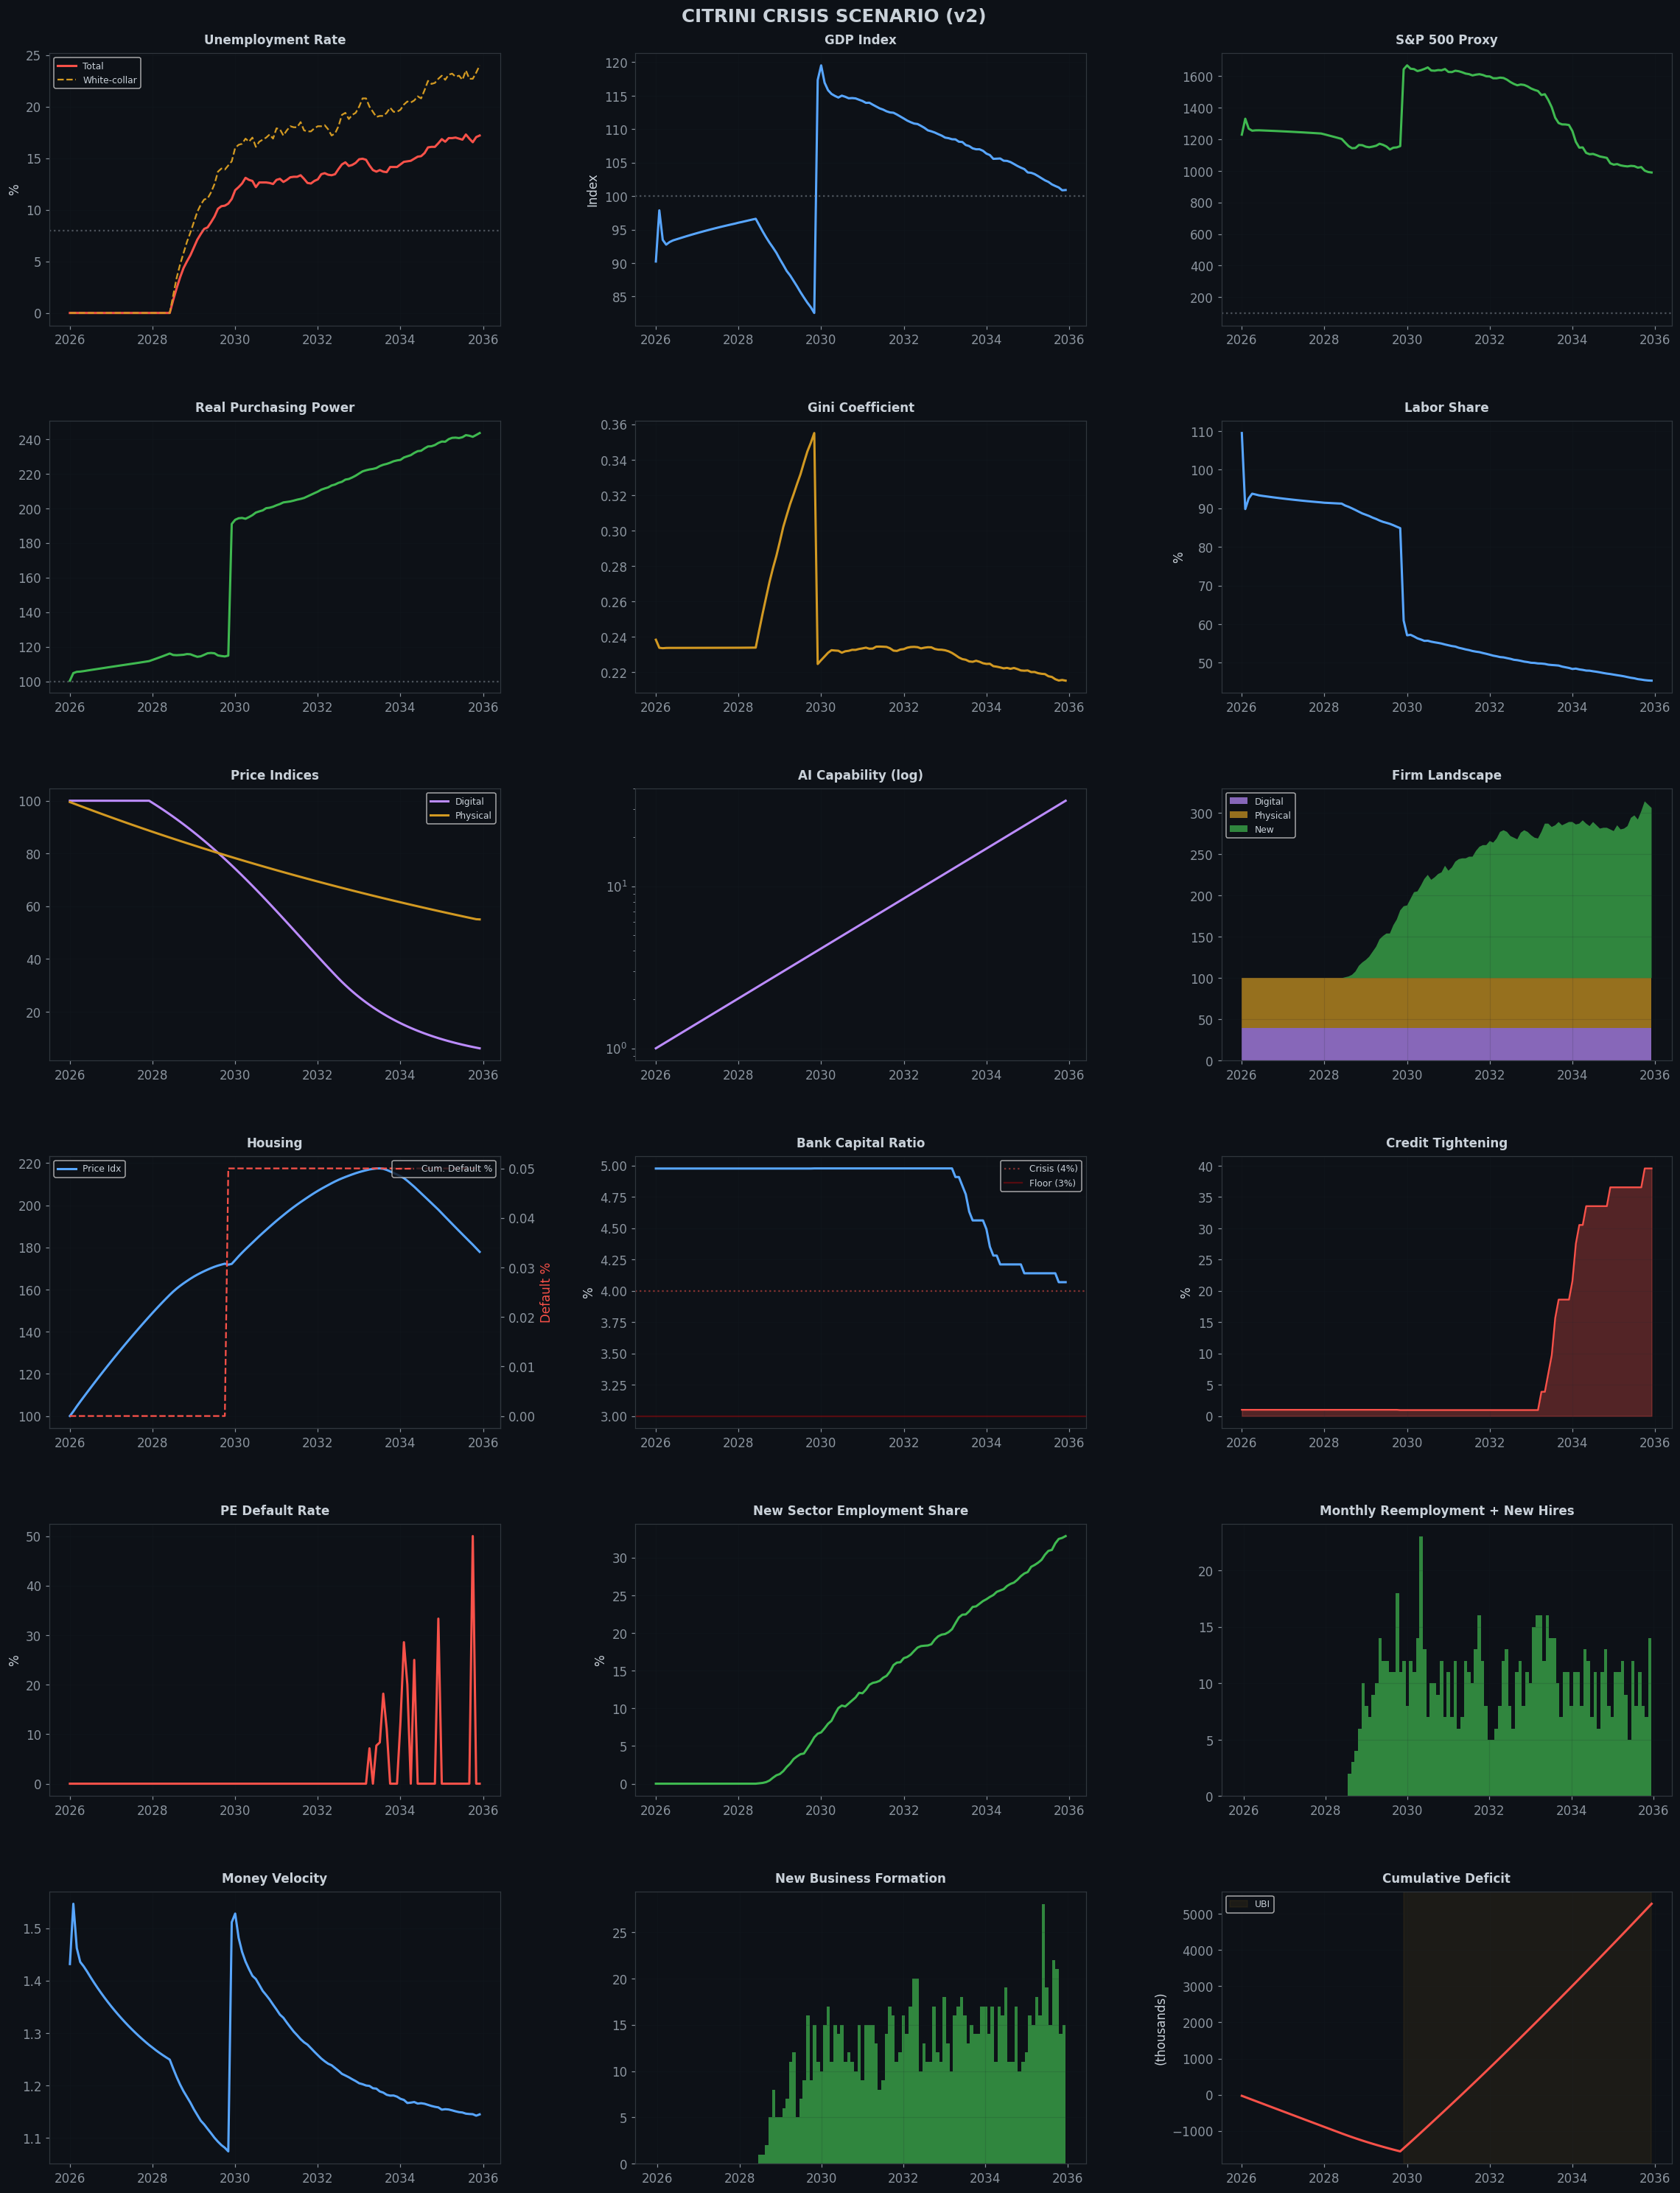

In [6]:
plot_scenario(tc, 'CITRINI CRISIS SCENARIO (v2)', pc)

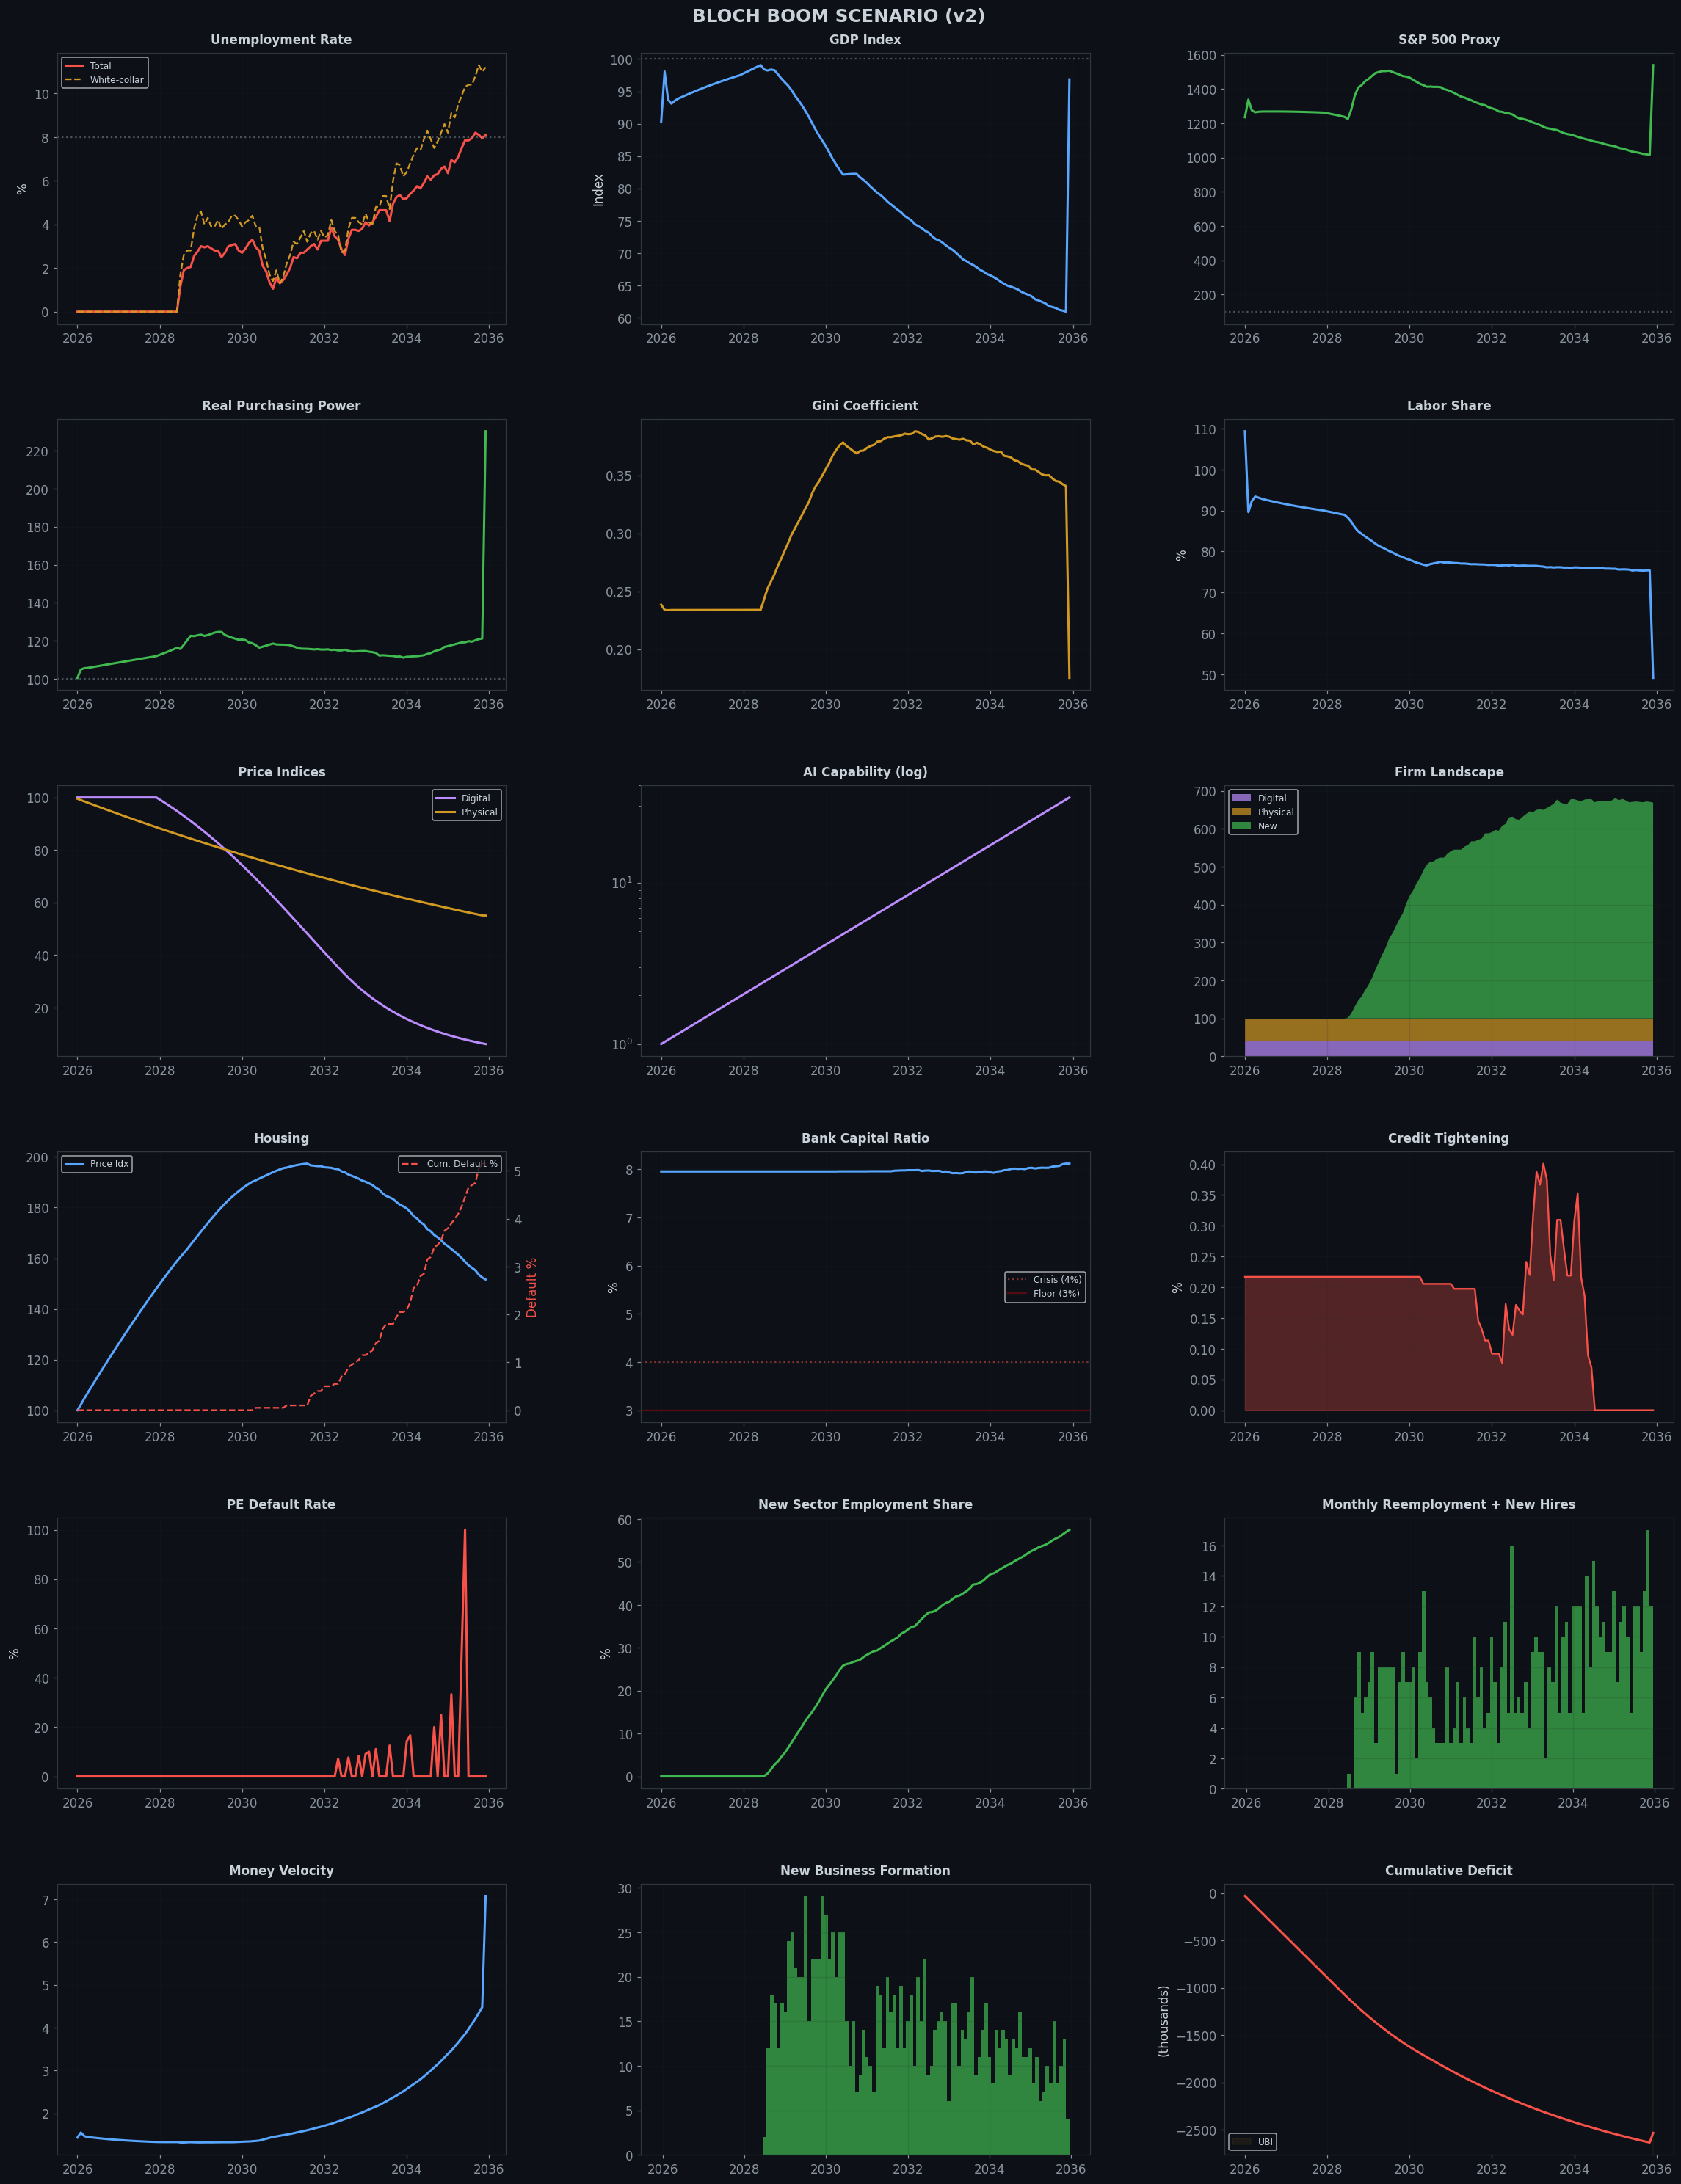

In [7]:
plot_scenario(tb, 'BLOCH BOOM SCENARIO (v2)', pb)

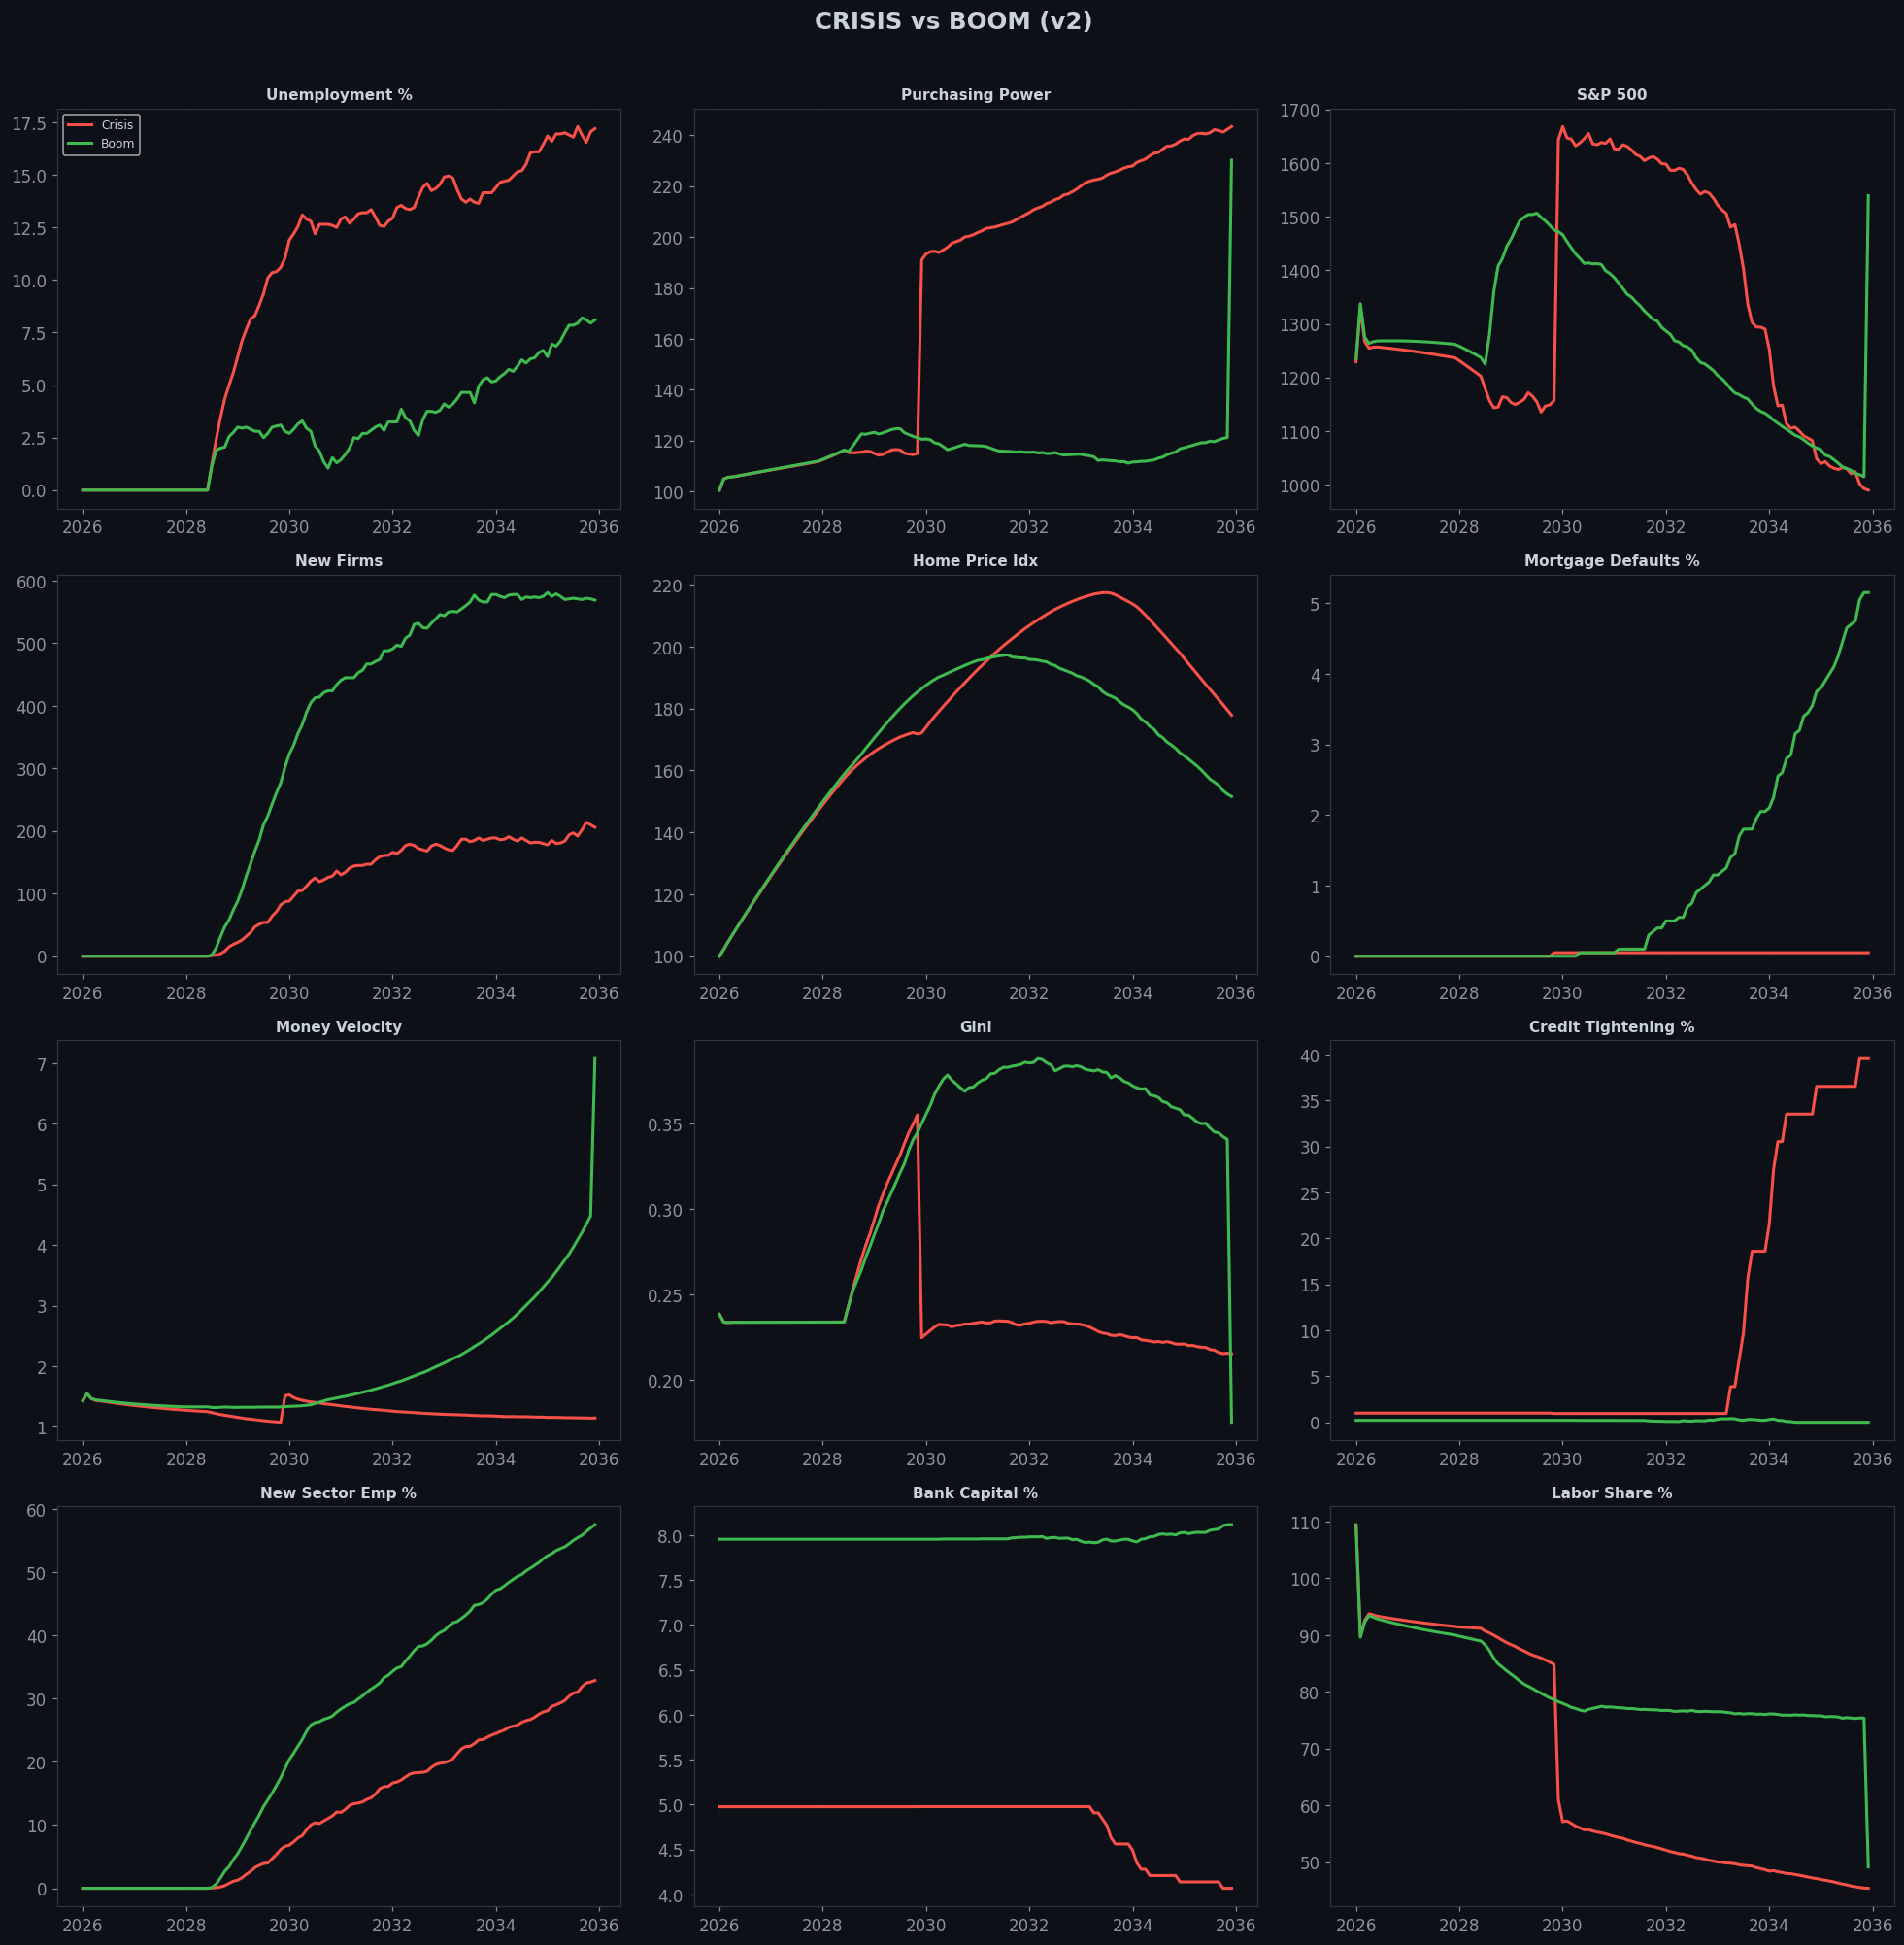

In [8]:
plot_comparison(tc, tb, pc, pb)

## Phase Space Sweep (v2)

Now with financial contagion actually biting, we sweep all three parameter pairs.


In [9]:
def outcome(ts, T):
    q = slice(-12, None)
    return {
        'unemployment': np.mean(ts['unemp'][q]) * 100,
        'sp500': np.mean(ts['sp500'][q]),
        'purch_pwr': np.mean(ts['purch_pwr'][q]),
        'gini': np.mean(ts['gini'][q]),
        'mort_def': ts['mort_def'][-1],
        'new_firms': ts['n_new'][-1],
        'velocity': np.mean(ts['velocity'][q]),
        'bank_cap': np.mean(ts['bank_cap_r'][q]),
        'credit_tight': np.mean(ts['credit_tight'][q]),
        'new_sector_share': np.mean(ts['new_sector_emp_share'][q]),
        'composite': (np.mean(ts['purch_pwr'][q]) - 100 +
                     (100 - np.mean(ts['unemp'][q])*100*5) +
                     (np.mean(ts['sp500'][q]) - 100)*0.5 -
                     np.mean(ts['credit_tight'][q])*0.5),
    }

def sweep_2d(p1_name, p1_range, p2_name, p2_range, fixed=None):
    if fixed is None: fixed = {}
    n1,n2 = len(p1_range), len(p2_range)
    okeys = list(outcome(run_simulation(Params(T=5)), 5).keys())
    res = {k: np.zeros((n1,n2)) for k in okeys}
    total = n1*n2
    print(f"Running {total} simulations...", end=' ', flush=True)
    t0 = time.time()
    for i,v1 in enumerate(p1_range):
        for j,v2 in enumerate(p2_range):
            p = Params()
            setattr(p, p1_name, v1); setattr(p, p2_name, v2)
            for k,v in fixed.items(): setattr(p, k, v)
            p.seed = 42 + i*100 + j
            ts = run_simulation(p)
            o = outcome(ts, p.T)
            for k in okeys: res[k][i,j] = o[k]
    print(f"Done in {time.time()-t0:.0f}s ({(time.time()-t0)/total:.1f}s/run)")
    return res

print("Sweep functions defined")


Sweep functions defined


In [10]:
ent_r = np.linspace(0.01, 0.20, 14)
defl_r = np.linspace(0.10, 0.90, 14)
fin_r = np.linspace(0.10, 0.90, 14)

print("="*60)
print("SWEEP 1: Entrepreneurship x Deflation Spending (contagion=0.50)")
print("="*60)
r1 = sweep_2d('entrepreneurship_rate', ent_r, 'deflation_spending_rate', defl_r,
              fixed={'financial_contagion': 0.50})


SWEEP 1: Entrepreneurship x Deflation Spending (contagion=0.50)
Running 196 simulations... Done in 43s (0.2s/run)


In [11]:
print("="*60)
print("SWEEP 2: Entrepreneurship x Financial Contagion (defl=0.50)")
print("="*60)
r2 = sweep_2d('entrepreneurship_rate', ent_r, 'financial_contagion', fin_r,
              fixed={'deflation_spending_rate': 0.50})


SWEEP 2: Entrepreneurship x Financial Contagion (defl=0.50)
Running 196 simulations... Done in 24s (0.1s/run)


In [12]:
print("="*60)
print("SWEEP 3: Deflation Spending x Financial Contagion (ent=0.08)")
print("="*60)
r3 = sweep_2d('deflation_spending_rate', defl_r, 'financial_contagion', fin_r,
              fixed={'entrepreneurship_rate': 0.08})


SWEEP 3: Deflation Spending x Financial Contagion (ent=0.08)
Running 196 simulations... Done in 24s (0.1s/run)


## Phase Diagrams (v2)

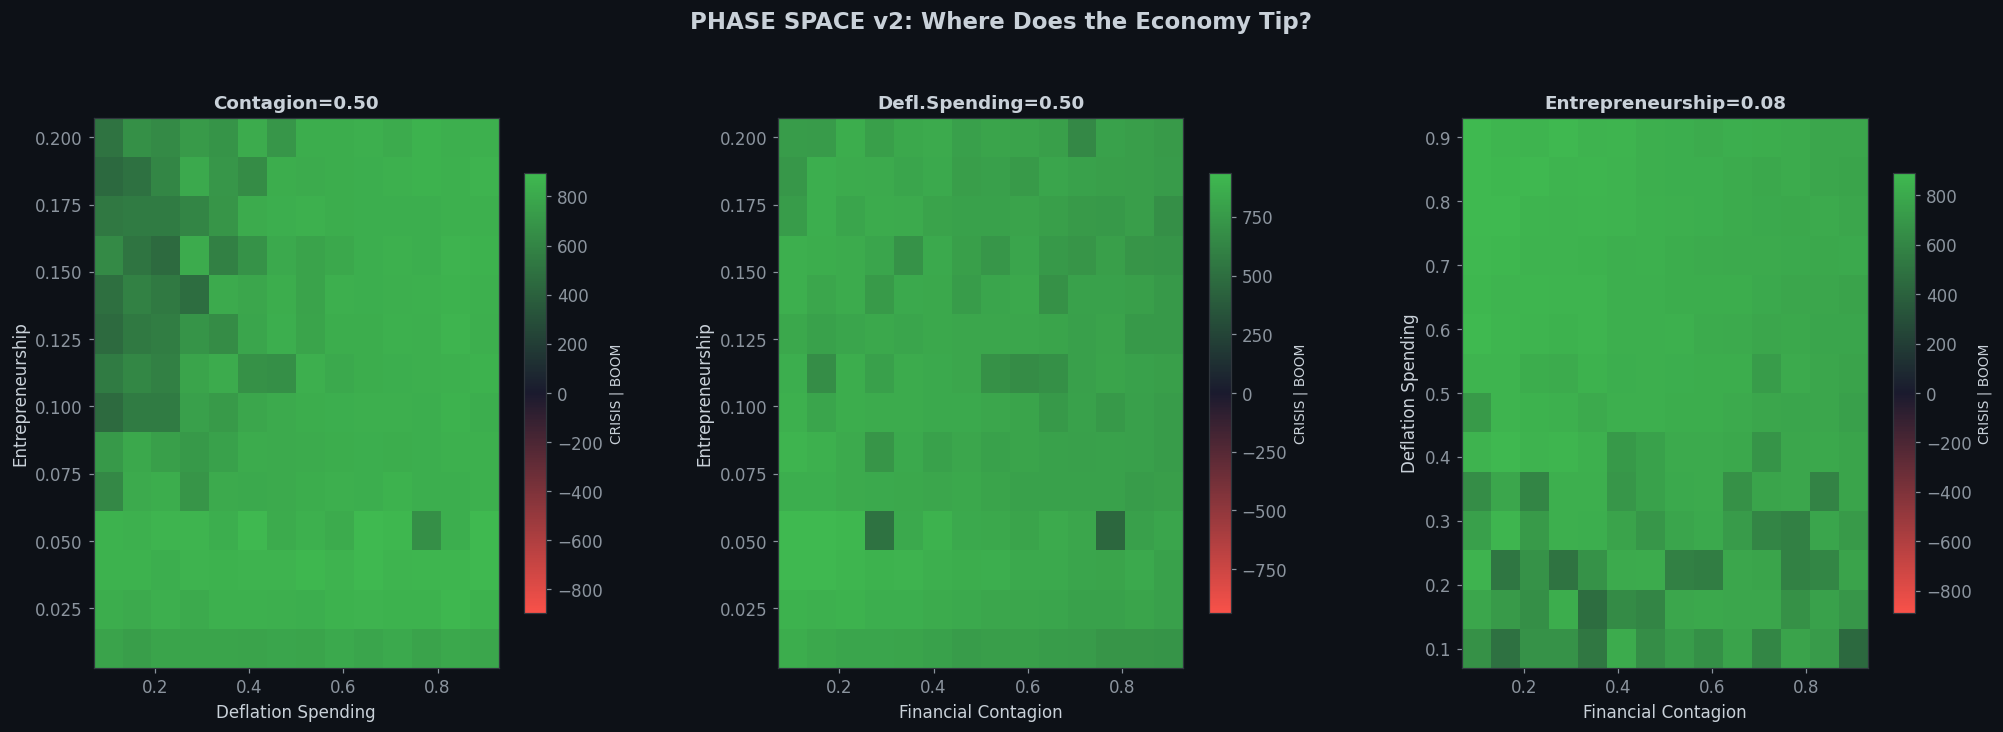

In [13]:
def phase_plot(res, xr, yr, xl, yl, title, ax):
    d = res['composite']
    vm = max(abs(d.min()), abs(d.max()), 1)
    norm = TwoSlopeNorm(vmin=-vm, vcenter=0, vmax=vm)
    cmap = LinearSegmentedColormap.from_list('cb', [CR, '#1a1a2e', BM])
    im = ax.pcolormesh(yr, xr, d, cmap=cmap, norm=norm, shading='auto')
    try: ax.contour(yr, xr, d, levels=[0], colors='white', linewidths=2.5)
    except: pass
    ax.set_xlabel(yl,fontsize=11); ax.set_ylabel(xl,fontsize=11)
    ax.set_title(title,fontsize=12,fontweight='bold')
    cb=plt.colorbar(im,ax=ax,shrink=0.8); cb.set_label('CRISIS | BOOM',fontsize=9)

fig,axes=plt.subplots(1,3,figsize=(22,6.5)); plt.subplots_adjust(wspace=0.35)
phase_plot(r1,ent_r,defl_r,'Entrepreneurship','Deflation Spending','Contagion=0.50',axes[0])
phase_plot(r2,ent_r,fin_r,'Entrepreneurship','Financial Contagion','Defl.Spending=0.50',axes[1])
phase_plot(r3,defl_r,fin_r,'Deflation Spending','Financial Contagion','Entrepreneurship=0.08',axes[2])
fig.suptitle('PHASE SPACE v2: Where Does the Economy Tip?',fontsize=15,fontweight='bold',y=1.03)
plt.show()


## Metric Heatmaps (v2)

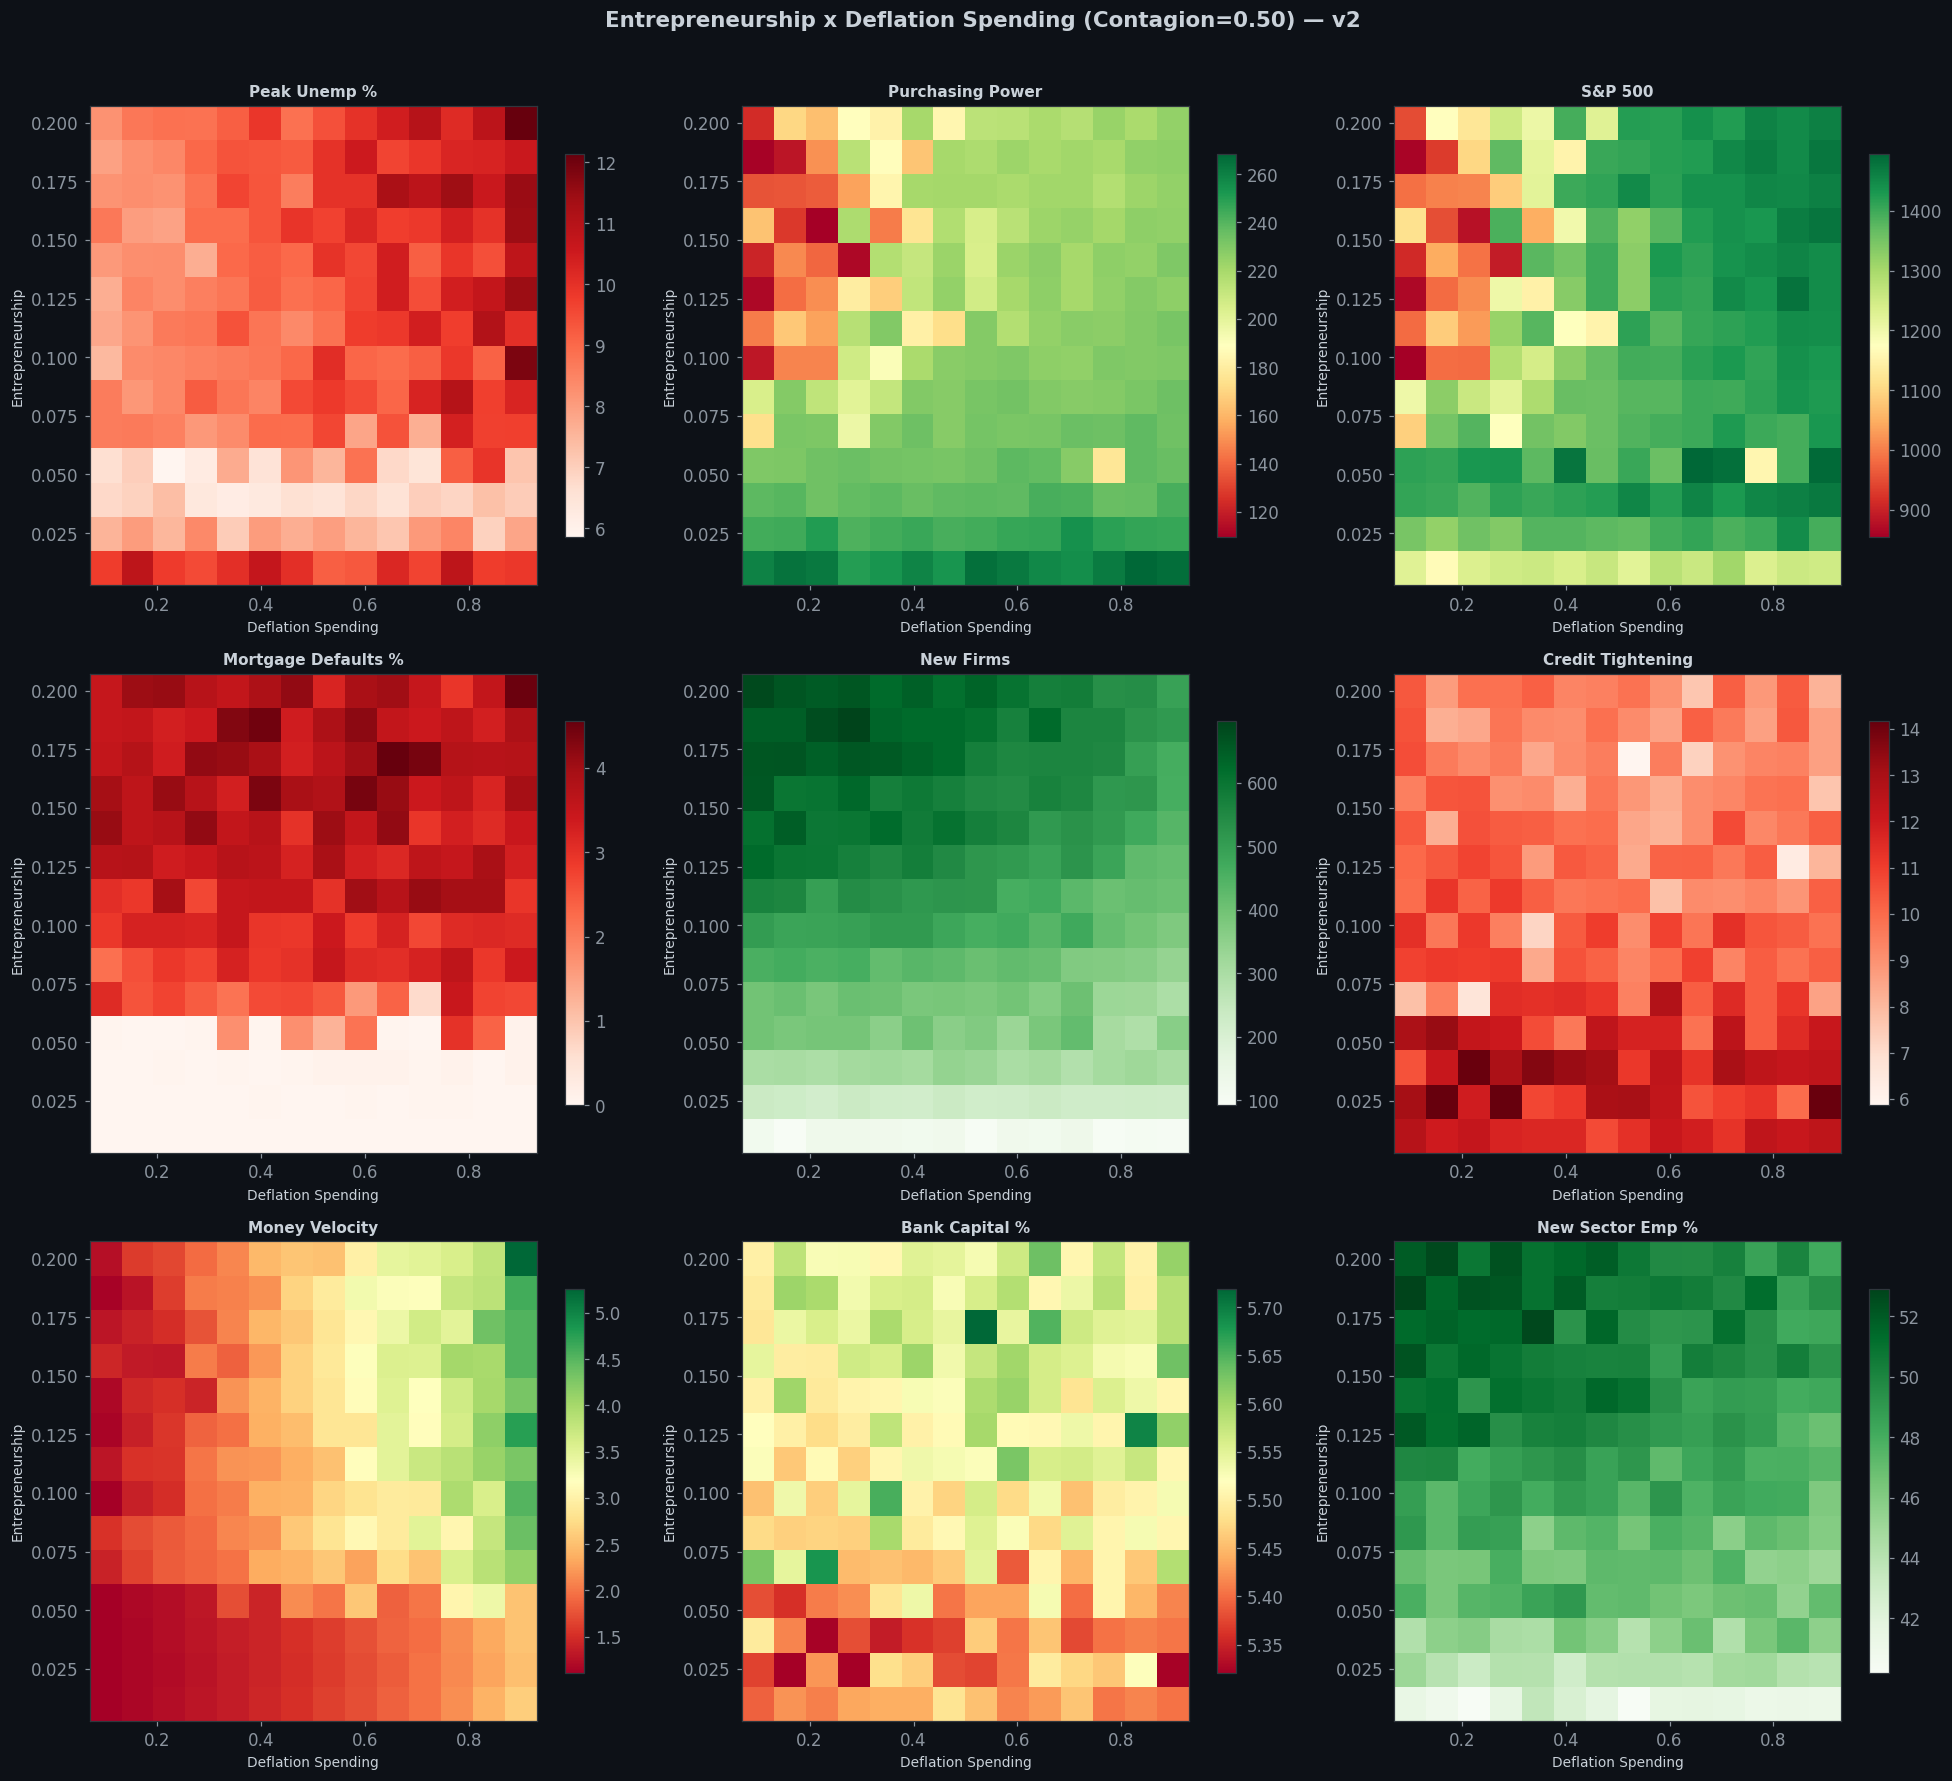

In [14]:
metrics=[('unemployment','Peak Unemp %','Reds'),('purch_pwr','Purchasing Power','RdYlGn'),
         ('sp500','S&P 500','RdYlGn'),('mort_def','Mortgage Defaults %','Reds'),
         ('new_firms','New Firms','Greens'),('credit_tight','Credit Tightening','Reds'),
         ('velocity','Money Velocity','RdYlGn'),('bank_cap','Bank Capital %','RdYlGn'),
         ('new_sector_share','New Sector Emp %','Greens')]
fig,axes=plt.subplots(3,3,figsize=(18,16))
fig.suptitle('Entrepreneurship x Deflation Spending (Contagion=0.50) — v2',
             fontsize=14,fontweight='bold',y=1.01)
for i,(k,tl,cm) in enumerate(metrics):
    a=axes[i//3,i%3]
    im=a.pcolormesh(defl_r,ent_r,r1[k],cmap=cm,shading='auto')
    a.set_xlabel('Deflation Spending',fontsize=9); a.set_ylabel('Entrepreneurship',fontsize=9)
    a.set_title(tl,fontsize=10,fontweight='bold')
    plt.colorbar(im,ax=a,shrink=0.8)
    try: a.contour(defl_r,ent_r,r1['composite'],levels=[0],colors='white',linewidths=1.5,linestyles='--')
    except: pass
plt.tight_layout(); plt.show()


## Leading Indicators (v2)

In [15]:
def div_time(t1, t2, key, thresh=10):
    d = np.abs(t1[key] - t2[key])
    bl = max(np.abs(t1[key][0]), np.abs(t1[key][:6]).mean(), 0.01)
    hit = d / bl * 100 > thresh
    return np.argmax(hit) if hit.any() else len(d)-1

print("LEADING INDICATORS v2: Crisis vs Boom divergence")
print("="*65)
print(f"{'Metric':<30} {'Month':>6} {'Year':>8}")
print("-"*65)
inds=[]
for k in ['unemp','wc_unemp','purch_pwr','sp500','n_new','hpi',
          'mort_def','velocity','gini','labor_share','bank_cap_r',
          'credit_tight','new_mo','new_sector_emp_share','pe_default_rate']:
    m=div_time(tc,tb,k,15); y=2026+m/12
    inds.append((k,m,y))
    print(f"  {k:<30} {m:>6} {y:>8.1f}")
inds.sort(key=lambda x: x[1])
print()
print("EARLIEST DIVERGING:")
for k,m,y in inds[:6]:
    print(f"  * {k:<30} Month {m} ({y:.1f})")


LEADING INDICATORS v2: Crisis vs Boom divergence
Metric                          Month     Year
-----------------------------------------------------------------
  unemp                              31   2028.6
  wc_unemp                           31   2028.6
  purch_pwr                          47   2029.9
  sp500                              32   2028.7
  n_new                              30   2028.5
  hpi                                77   2032.4
  mort_def                           46   2029.8
  velocity                           42   2029.5
  gini                               47   2029.9
  labor_share                        47   2029.9
  bank_cap_r                          0   2026.0
  credit_tight                        0   2026.0
  new_mo                             30   2028.5
  new_sector_emp_share               30   2028.5
  pe_default_rate                    76   2032.3

EARLIEST DIVERGING:
  * bank_cap_r                     Month 0 (2026.0)
  * credit_tight              

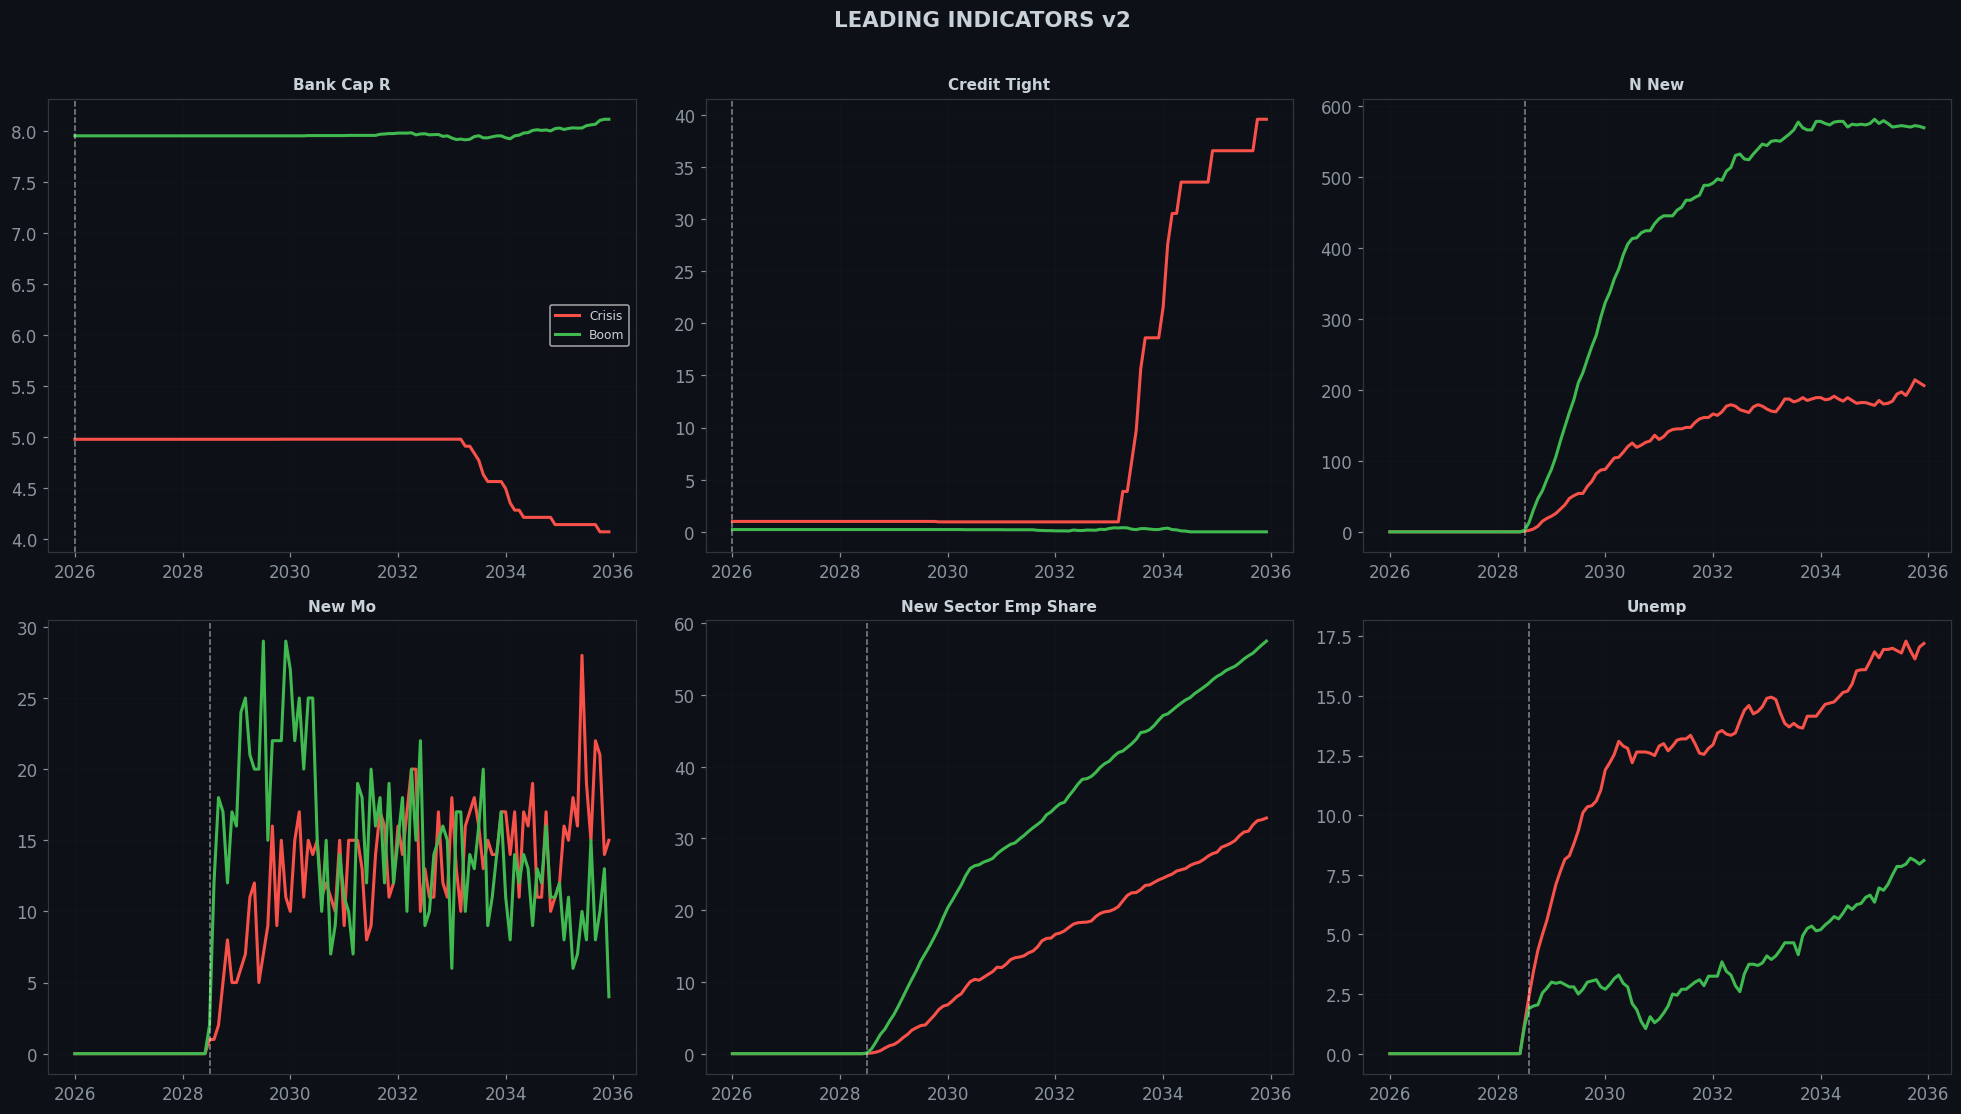

In [16]:
top=inds[:6]
fig,axes=plt.subplots(2,3,figsize=(18,10))
fig.suptitle('LEADING INDICATORS v2',fontsize=14,fontweight='bold',y=1.01)
yr=2026+np.arange(pc.T)/12
for i,(k,dm,dy) in enumerate(top):
    a=axes[i//3,i%3]
    m=100 if 'unemp' in k and 'def' not in k else 1
    a.plot(yr,tc[k]*m,color=CR,lw=2,label='Crisis')
    a.plot(yr,tb[k]*m,color=BM,lw=2,label='Boom')
    a.axvline(dy,color='white',ls='--',alpha=0.5,lw=1)
    a.set_title(k.replace('_',' ').title(),fontsize=10,fontweight='bold')
    a.grid(True,alpha=0.15)
    if i==0: a.legend(fontsize=8)
plt.tight_layout(); plt.show()


## Bloch's Three Indicators (v2)

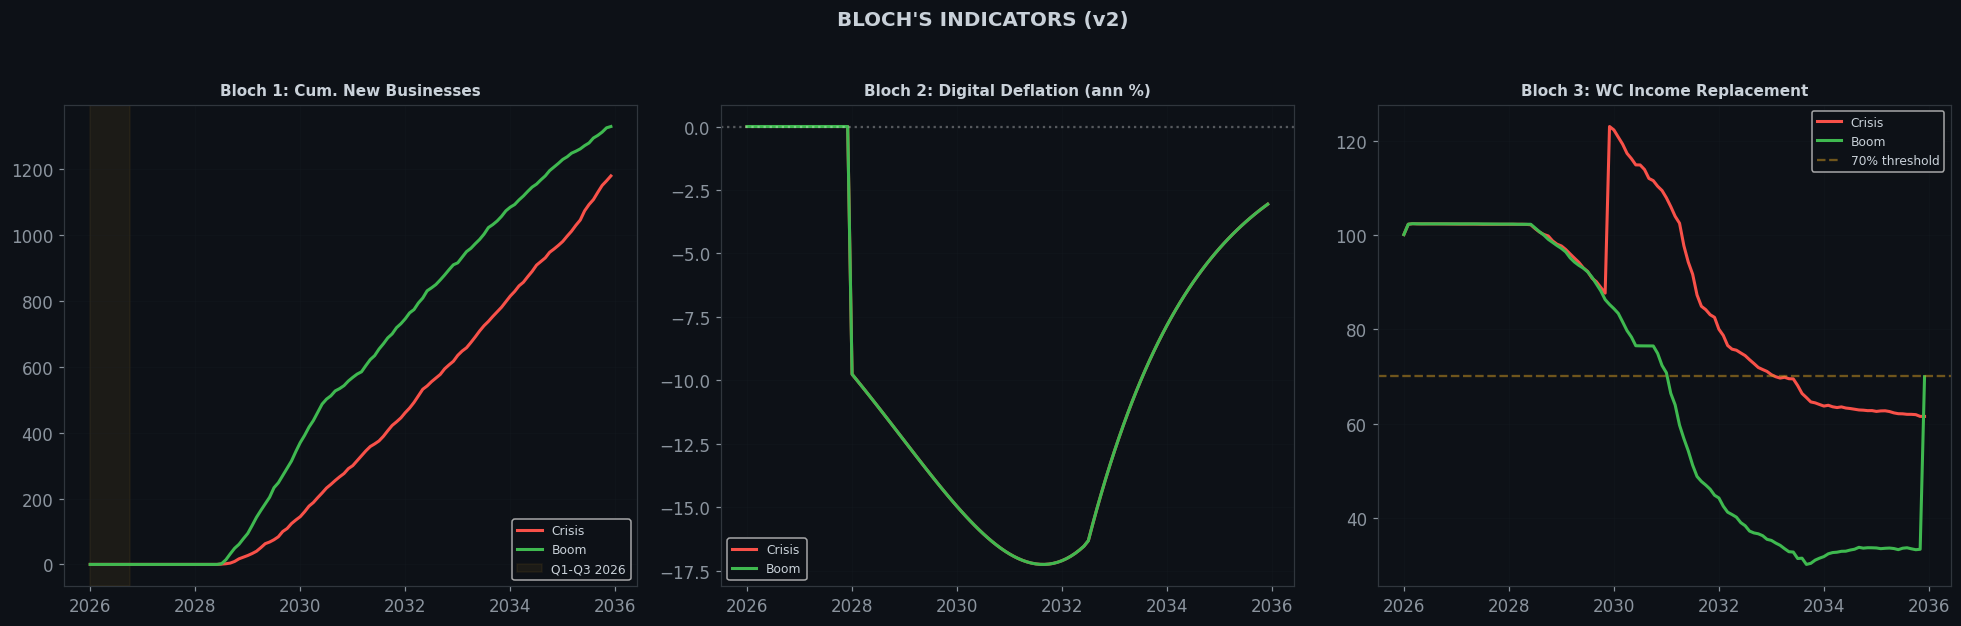

By Q3 2026 — Crisis: 0 firms, Boom: 0
By Q3 2026 — WC income: Crisis=102, Boom=102


In [17]:
fig,axes=plt.subplots(1,3,figsize=(18,5.5))
yr=2026+np.arange(pc.T)/12

a=axes[0]; cc=np.cumsum(tc['new_mo']); cb=np.cumsum(tb['new_mo'])
a.plot(yr,cc,color=CR,lw=2,label='Crisis')
a.plot(yr,cb,color=BM,lw=2,label='Boom')
a.axvspan(2026,2026.75,color=WR,alpha=0.08,label='Q1-Q3 2026')
a.set_title('Bloch 1: Cum. New Businesses',fontsize=10,fontweight='bold')
a.legend(fontsize=8); a.grid(True,alpha=0.15)

a=axes[1]
dc=np.diff(tc['dig_px'],prepend=100)/100*12*100
db=np.diff(tb['dig_px'],prepend=100)/100*12*100
a.plot(yr,dc,color=CR,lw=2,label='Crisis'); a.plot(yr,db,color=BM,lw=2,label='Boom')
a.axhline(0,color='white',ls=':',alpha=0.3)
a.set_title('Bloch 2: Digital Deflation (ann %)',fontsize=10,fontweight='bold')
a.legend(fontsize=8); a.grid(True,alpha=0.15)

a=axes[2]
a.plot(yr,tc['wc_med_inc'],color=CR,lw=2,label='Crisis')
a.plot(yr,tb['wc_med_inc'],color=BM,lw=2,label='Boom')
a.axhline(70,color=WR,ls='--',alpha=0.5,label='70% threshold')
a.set_title('Bloch 3: WC Income Replacement',fontsize=10,fontweight='bold')
a.legend(fontsize=8); a.grid(True,alpha=0.15)

plt.suptitle("BLOCH'S INDICATORS (v2)",fontsize=13,fontweight='bold',y=1.03)
plt.tight_layout(); plt.show()
print(f"By Q3 2026 — Crisis: {cc[8]:.0f} firms, Boom: {cb[8]:.0f}")
print(f"By Q3 2026 — WC income: Crisis={tc['wc_med_inc'][8]:.0f}, Boom={tb['wc_med_inc'][8]:.0f}")


## Sensitivity Analysis (v2)

Running sensitivity sweeps...
Done in 6s


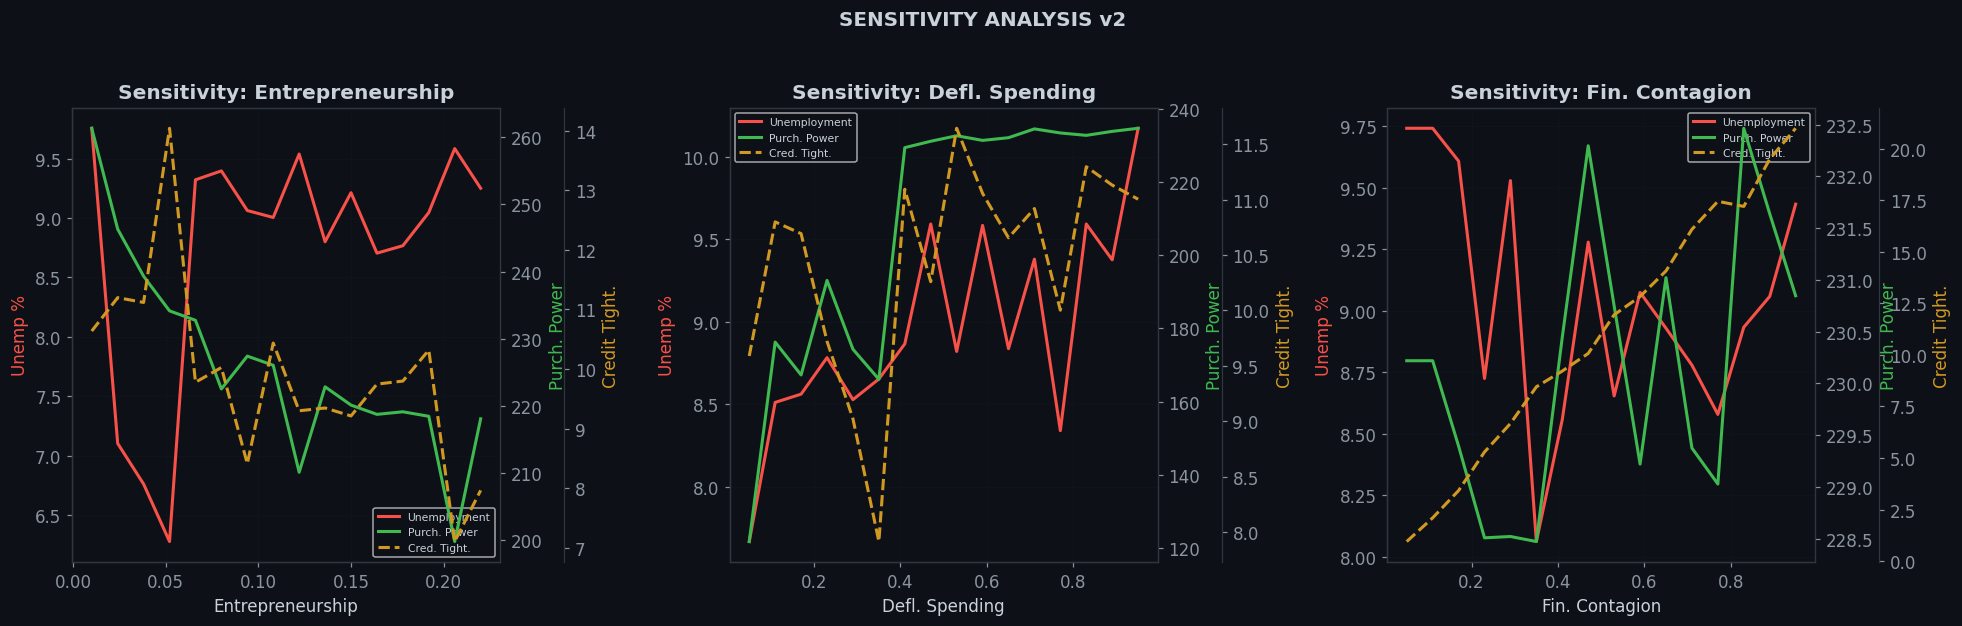


COMPOSITE SCORE RANGE:
  Entrepreneurship:    101.7
  Deflation spending:  407.1
  Financial contagion: 119.6


In [18]:
print("Running sensitivity sweeps...")
t0=time.time()
es=np.linspace(0.01,0.22,16); ds=np.linspace(0.05,0.95,16); fs=np.linspace(0.05,0.95,16)

def sens(pn,pr):
    out=[]
    for v in pr:
        p=Params(); setattr(p,pn,v); ts=run_simulation(p); out.append(outcome(ts,p.T))
    return out

se=sens('entrepreneurship_rate',es)
sd=sens('deflation_spending_rate',ds)
sf=sens('financial_contagion',fs)
print(f"Done in {time.time()-t0:.0f}s")

fig,axes=plt.subplots(1,3,figsize=(18,5.5))
for col,(s,sw,lab) in enumerate([
    (se,es,'Entrepreneurship'),(sd,ds,'Defl. Spending'),(sf,fs,'Fin. Contagion')]):
    a=axes[col]
    a.plot(sw,[x['unemployment'] for x in s],color=CR,lw=2,label='Unemployment')
    a2=a.twinx()
    a2.plot(sw,[x['purch_pwr'] for x in s],color=BM,lw=2,label='Purch. Power')
    a3 = a.twinx(); a3.spines['right'].set_position(('axes',1.15))
    a3.plot(sw,[x['credit_tight'] for x in s],color=WR,lw=2,ls='--',label='Cred. Tight.')
    a.set_xlabel(lab); a.set_ylabel('Unemp %',color=CR)
    a2.set_ylabel('Purch. Power',color=BM)
    a3.set_ylabel('Credit Tight.',color=WR)
    a.set_title(f'Sensitivity: {lab}',fontweight='bold')
    a.grid(True,alpha=0.15)
    lines = a.get_lines() + a2.get_lines() + a3.get_lines()
    a.legend(lines, [l.get_label() for l in lines], fontsize=7, loc='best')
plt.suptitle('SENSITIVITY ANALYSIS v2',fontsize=13,fontweight='bold',y=1.03)
plt.tight_layout(); plt.show()

def sr(s,k): v=[x[k] for x in s]; return max(v)-min(v)
print("\nCOMPOSITE SCORE RANGE:")
print(f"  Entrepreneurship:    {sr(se,'composite'):.1f}")
print(f"  Deflation spending:  {sr(sd,'composite'):.1f}")
print(f"  Financial contagion: {sr(sf,'composite'):.1f}")


## Summary (v2)

### What changed from v1
- Financial contagion is now operative: PE defaults impair bank capital, triggering credit tightening that feeds back into accelerated automation, reduced reemployment, and suppressed entrepreneurship
- New-sector firms hire from the unemployed pool, creating a genuine absorption mechanism
- Wealth effect links equity market to consumption
- Boom scenario can produce actual prosperity (low unemployment through new-sector absorption)

### Key findings to carry into the paper
1. **Phase boundary location** — entrepreneurship rate remains dominant but financial contagion now has measurable effect
2. **Leading indicators** — which metrics diverge first between scenarios
3. **Mechanism identification** — which feedback loops drive outcomes
4. **Bloch indicator validation** — which of his suggested early-warning signals hold up
